#Introduction

In this project, we'll be examining MLB player stats for everyone who played in the 2019 season. The data is collected from baseball-reference.com and can be found [here](https://www.baseball-reference.com/leagues/MLB/2019-standard-batting.shtml#players_standard_batting::none). The premise is we're preparing for a 2020 fantasy baseball draft, and we want to cluster players who produce similar, fantasy-relevant scoring statistics.

The goal is to identify clusters of players who had high value in 2019, as well as those who had high value, but in a smaller sample of games played, meaning they might be much harder to identify otherwise.

After importing and cleaning the data, and after generating and selecting features, we'll explore reducing the dimensionality of the data using PCA, t-SNE, and UMAP. After selecting the best reduction, we'll apply several clustering methods, specifically K-mean, Agglomeration, and DBSCAN.

The generated clusters will then be inspected, and their defining traits identified.

#Import Necessary Modules

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import umap
from scipy.stats.mstats import winsorize
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn import metrics

#Data Import and Cleaning

Data is imported, missing values are handled, and we inspect for outliers.

In [0]:
# data is imported from baseball-reference .csv which contains control character whitespace not supported by utf-8
player_stats = pd.read_csv("https://github.com/ADEnnaco/datasets/raw/master/MLB2019_player_stats.csv", encoding='latin1')
player_stats = player_stats.replace(u'\xa0', u' ', regex=True)
player_stats.columns = player_stats.columns.str.replace(u'\xa0', u' ', regex=True)

In [44]:
player_stats.head()

,Name,ID,Age,Tm,Lg,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,BA,OBP,SLG,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB,Pos Summary
0,Fernando Abad*,abadfe01,33.0,SFG,NL,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1
1,José Abreu,abreujo02,32.0,CHW,AL,159.0,693.0,634.0,85.0,180.0,38.0,1.0,33.0,123.0,2.0,2.0,36.0,152.0,0.284,0.330,0.503,0.834,119.0,319.0,24.0,13.0,0.0,10.0,4.0,*3D
2,Ronald Acuna Jr.,acunaro01,21.0,ATL,NL,156.0,715.0,626.0,127.0,175.0,22.0,2.0,41.0,101.0,37.0,9.0,76.0,188.0,0.280,0.365,0.518,0.883,122.0,324.0,8.0,9.0,0.0,1.0,4.0,*879
3,Jason Adam,adamja01,27.0,TOR,AL,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1
4,Cristhian Adames#,adamecr01,27.0,SFG,NL,10.0,24.0,22.0,1.0,7.0,1.0,0.0,0.0,2.0,0.0,0.0,2.0,8.0,0.318,0.375,0.364,0.739,100.0,8.0,0.0,0.0,0.0,0.0,0.0,/45


##Column Descriptions

**Name** -- Player Name
- \* means LHP or LHB,
- \# means switch hitter

**ID** -- Unique player id

**Age** -- Player’s age at midnight of June 30th of that year

**Tm** -- Team
- TOT indicates multiple teams

**Lg** -- League
- AL - American League
- NL - National League
- MLB - Both

**G** -- Games Played

- This includes all times that the player appeared on the lineup card. Pitchers in non-DH games that appeared on the lineup card but didn't bat will still have a game in this column.

**PA** -- Plate Appearances
- When available, we use actual plate appearances from play-by-play game accounts. Otherwise estimated using AB + BB + HBP + SF + SH, which excludes catcher interferences.

**AB** -- At Bats

**R** -- Runs Scored

**H** -- Hits

**2B** -- Doubles Hit

**3B** -- Triples Hit

**HR** -- Home Runs Hit

**RBI** -- Runs Batted In

**SB** -- Stolen Bases

**CS** -- Caught Stealing

**BB** -- Bases on Balls

**SO** -- Strikeouts

**BA** -- Hits/At Bats
- For recent years, leaders need 3.1 PA per team game played

**OBP** -- (H + BB + HBP)/(At Bats + BB + HBP + SF)
- For recent years, leaders need 3.1 PA per team game played

**SLG** -- Total Bases/At Bats or (1B + 2*2B + 3*3B + 4*HR)/AB
- For recent years, leaders need 3.1 PA per team game played

**OPS** -- On-Base + Slugging Percentages
- For recent years, leaders need 3.1 PA per team game played

**OPS+** -- OPS+
- 100*[OBP/lg OBP + SLG/lg SLG - 1]
- Adjusted to the player’s ballpark(s)

**TB** -- Total Bases
- Singles + 2 x Doubles + 3 x Triples + 4 x Home Runs.

**GDP** -- Double Plays Grounded Into
- Only includes standard 6-4-3, 4-3, etc. double plays.
- First tracked in 1933.

**HBP** -- Times Hit by a Pitch.

**SH** -- Sacrifice Hits (Sacrifice Bunts)

**SF** -- Sacrifice Flies

**IBB** -- Intentional Bases on Balls

**Pos Summary** -- Positions Played
- The positions either followed by the games played at that position or in order of games or innings played.
- For a single season, * indicates they played at least 2/3rds of the team games there.
- Positions after / indicate less than ten games played at those positions.

##Missing Values

In [45]:
player_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1289 entries, 0 to 1288
Data columns (total 30 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         1287 non-null   object 
 1   ID           1287 non-null   object 
 2   Age          1287 non-null   float64
 3   Tm           1287 non-null   object 
 4   Lg           1287 non-null   object 
 5   G            1287 non-null   float64
 6   PA           1287 non-null   float64
 7   AB           1287 non-null   float64
 8   R            1287 non-null   float64
 9   H            1287 non-null   float64
 10  2B           1287 non-null   float64
 11  3B           1287 non-null   float64
 12  HR           1287 non-null   float64
 13  RBI          1287 non-null   float64
 14  SB           1287 non-null   float64
 15  CS           1287 non-null   float64
 16  BB           1287 non-null   float64
 17  SO           1287 non-null   float64
 18  BA           983 non-null    float64
 19  OBP   

In [46]:
# At first glance, it looks like every column has at least 2 missing values.
# We start by removing rows where all values are null to see if that handles it.
player_stats = player_stats.dropna(axis=0, how='all')
player_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1287 entries, 0 to 1286
Data columns (total 30 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         1287 non-null   object 
 1   ID           1287 non-null   object 
 2   Age          1287 non-null   float64
 3   Tm           1287 non-null   object 
 4   Lg           1287 non-null   object 
 5   G            1287 non-null   float64
 6   PA           1287 non-null   float64
 7   AB           1287 non-null   float64
 8   R            1287 non-null   float64
 9   H            1287 non-null   float64
 10  2B           1287 non-null   float64
 11  3B           1287 non-null   float64
 12  HR           1287 non-null   float64
 13  RBI          1287 non-null   float64
 14  SB           1287 non-null   float64
 15  CS           1287 non-null   float64
 16  BB           1287 non-null   float64
 17  SO           1287 non-null   float64
 18  BA           983 non-null    float64
 19  OBP   

In [47]:
# Next, we examine the 5 rows where 'Pos Summary' is 
player_stats[player_stats['Pos Summary'].isna()]

,Name,ID,Age,Tm,Lg,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,BA,OBP,SLG,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB,Pos Summary
144,Rob Brantly*,brantro01,29.0,PHI,NL,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000,0.0,0.000,-100.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
254,Dylan Cozens*,cozendy01,25.0,PHI,NL,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,-100.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
563,Joe Hudson,hudsojo03,28.0,STL,NL,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000,0.0,0.000,-100.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
677,Jed Lowrie#,lowrije01,35.0,NYM,NL,9.0,8.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.125,0.0,0.125,-61.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1214,Mitch Walding*,waldimi01,26.0,PHI,NL,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.000,0.0,0.000,-100.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [0]:
# Rows contain no other missing values.
# We replace 'Pos Summary' with values from 2018 or suitable ones based on external data
replacements = {144: '/2D1',  # backup C, DH and 1B
                254: '/9',    # backup RF
                563: '/2',    # backup C
                677: '/45D',  # backup 2B, 3B, and DH
                1214: '/5',   # backup 3B
                }

# fill in missing positions
for index in replacements.keys():
  player_stats.loc[index, 'Pos Summary'] = replacements[index]

In [49]:
player_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1287 entries, 0 to 1286
Data columns (total 30 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         1287 non-null   object 
 1   ID           1287 non-null   object 
 2   Age          1287 non-null   float64
 3   Tm           1287 non-null   object 
 4   Lg           1287 non-null   object 
 5   G            1287 non-null   float64
 6   PA           1287 non-null   float64
 7   AB           1287 non-null   float64
 8   R            1287 non-null   float64
 9   H            1287 non-null   float64
 10  2B           1287 non-null   float64
 11  3B           1287 non-null   float64
 12  HR           1287 non-null   float64
 13  RBI          1287 non-null   float64
 14  SB           1287 non-null   float64
 15  CS           1287 non-null   float64
 16  BB           1287 non-null   float64
 17  SO           1287 non-null   float64
 18  BA           983 non-null    float64
 19  OBP   

In [50]:
# examine rows where BA, OBP, SLG, OPS or OPS+ are null
print(player_stats[player_stats.isna().any(axis=1)],'\n')

# and confirm the positions of these players
print("Missing Value Positions:",player_stats[player_stats.isna().any(axis=1)]['Pos Summary'].unique())

                  Name         ID   Age   Tm  ...   SH   SF  IBB  Pos Summary
0       Fernando Abad*   abadfe01  33.0  SFG  ...  0.0  0.0  0.0            1
3           Jason Adam   adamja01  27.0  TOR  ...  0.0  0.0  0.0            1
6         Austin Adams  adamsau01  32.0  TOT  ...  0.0  0.0  0.0            1
15        Matt Albers*  alberma01  36.0  MIL  ...  0.0  0.0  0.0            1
19    Victor Alcantara  alcanvi01  26.0  DET  ...  0.0  0.0  0.0            1
...                ...        ...   ...  ...  ...  ...  ...  ...          ...
1272      Kirby Yates*  yateski01  32.0  SDP  ...  0.0  0.0  0.0            1
1274      Gabriel Ynoa   ynoaga01  26.0  BAL  ...  0.0  0.0  0.0            1
1275      Huascar Ynoa   ynoahu01  21.0  ATL  ...  0.0  0.0  0.0           /1
1278    Daniel Zamora*  zamorda01  26.0  NYM  ...  0.0  0.0  0.0            1
1282       Kyle Zimmer  zimmeky01  27.0  KCR  ...  0.0  0.0  0.0            1

[304 rows x 30 columns] 

Missing Value Positions: ['1' '/1' '1

Every single player with missing values in these hitting metrics is primarily a pitcher. We also note that pitchers will rarely have significant batting data, and even if they did, it's not a good way to cluster them. Therefore, we drop all players whose primary position is pitcher. Since part of our data processing will involve creating columns for each player position, we'll handle this after that step is completed.

##Data Processing

We fix data types, and create new variables based on player positions and which side of the plate they bat from.

In [0]:
# change columns with integer values to int
int_cols = [2] + list(range(5,18)) + list(range(23,29))
player_stats.iloc[:,int_cols] = player_stats.iloc[:,int_cols].astype(int)

###Function Definitions

We define the following functions:

- pitcher: identifies whether or not a player's primary position is pitcher.
- positional: identifies a player's positions, and assigns a value based on how many games were played at each position.
- handed: identifies which side of the plate a player bats from using symbolic data in the 'Name' field.

In [0]:
def pitcher(summary):
  '''
  Returns:
  1 if a player's primary position is pitcher
  0 otherwise
  '''
  if summary.replace('*','').replace('/','')[0] == '1':
    return 1
  else:
    return 0

def positional(summary, position):
  '''
  Assigns value to a player's time at a position

  summary: a baseball-reference positional summary

  position: player's positional category
    'catcher' - C
    'corner' - 1B or 3B
    'middle' - 2B or SS
    'outfield' - LF, CF or RF
    'DH' - DH

  returns:
    1 - played more than 2/3 of team games at position
    0.25 - played at least 10 games but not more than 2/3 of team games
    0.1 - played at least 1 game but not more than 10
    0 - didn't play any games at position  
  '''
  pos_dict = {'catcher': ['2'],
              'corner': ['3','5'],
              'middle': ['4','6'],
              'outfield': ['7','8','9'],
              'DH': 'D'}

  parts = summary.split('/')
  if len(parts) < 2:
    parts.append('')
  if (summary[0] == '*') and (summary[1] in pos_dict[position]):
    return 1
  elif set(pos_dict[position]) & set(parts[0]) != set():
    return 0.25
  elif set(pos_dict[position]) & set(parts[1]) != set():
    return 0.1
  else:
    return 0

def handed(name):
  if name[-1] == '*':   # Left Handed
    return 1
  elif name[-1] == '#': # Switch Hitter
    return 0.5
  else:                 # Right Handed
    return 0

###Add Positional Variables

In [0]:
# first we drop the pitchers
pitcher_indices = player_stats[player_stats['Pos Summary'].apply(pitcher) == 1].index
player_stats = player_stats.drop(pitcher_indices)

In [0]:
# create variables for each positional group
positional_categories = ['catcher', 'corner', 'middle', 'outfield', 'DH']
for cat in positional_categories:
  player_stats[cat] = player_stats['Pos Summary'].apply(positional, args=(cat,))

###Add Batting Hand Variable

In [55]:
# create variable for which side a player bats from
player_stats['handed'] = player_stats['Name'].apply(handed)

# remove handedness indicators from player names
player_stats['Name'] = player_stats['Name'].apply(lambda x: x[:-1] if x[-1] in ['*', '#'] else x)

# display head with new variables
player_stats.head(20)

,Name,ID,Age,Tm,Lg,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,BA,OBP,SLG,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB,Pos Summary,catcher,corner,middle,outfield,DH,handed
1,José Abreu,abreujo02,32,CHW,AL,159,693,634,85,180,38,1,33,123,2,2,36,152,0.284,0.330,0.503,0.834,119.0,319,24,13,0,10,4,*3D,0.00,1.00,0.00,0.00,0.25,0.0
2,Ronald Acuna Jr.,acunaro01,21,ATL,NL,156,715,626,127,175,22,2,41,101,37,9,76,188,0.280,0.365,0.518,0.883,122.0,324,8,9,0,1,4,*879,0.00,0.00,0.00,1.00,0.00,0.0
4,Cristhian Adames,adamecr01,27,SFG,NL,10,24,22,1,7,1,0,0,2,0,0,2,8,0.318,0.375,0.364,0.739,100.0,8,0,0,0,0,0,/45,0.00,0.10,0.10,0.00,0.00,0.5
5,Willy Adames,adamewi01,23,TBR,AL,152,584,531,69,135,25,1,20,52,4,2,46,153,0.254,0.317,0.418,0.735,95.0,222,9,3,3,1,1,*6,0.00,0.00,1.00,0.00,0.00,0.0
8,Matt Adams,adamsma01,30,WSN,NL,111,333,310,42,70,14,0,20,56,0,0,20,115,0.226,0.276,0.465,0.741,83.0,144,7,2,0,1,1,3,0.00,0.25,0.00,0.00,0.00,1.0
9,Jim Adduci,adducji02,34,CHC,NL,2,5,5,0,0,0,0,0,0,0,0,0,3,0.000,0.000,0.000,0.000,-100.0,0,0,0,0,0,0,/9,0.00,0.00,0.00,0.10,0.00,1.0
10,Ehire Adrianza,adriaeh01,29,MIN,AL,83,236,202,34,55,8,3,5,22,0,2,20,40,0.272,0.349,0.416,0.765,102.0,84,2,6,2,4,1,563/4971,0.00,0.25,0.25,0.10,0.00,0.5
12,Jesus Aguilar,aguilje01,29,TOT,MLB,131,369,314,39,74,12,0,12,50,0,0,43,81,0.236,0.325,0.389,0.714,87.0,122,12,2,0,7,0,3D/5,0.00,0.25,0.00,0.00,0.25,0.0
13,Nick Ahmed,ahmedni01,29,ARI,NL,158,625,556,79,141,33,6,19,82,8,2,52,113,0.254,0.316,0.437,0.753,93.0,243,15,4,1,12,2,*6,0.00,0.00,1.00,0.00,0.00,0.0
16,Hanser Alberto,alberha01,26,BAL,AL,139,550,524,62,160,21,2,12,51,4,4,16,50,0.305,0.329,0.422,0.751,98.0,221,9,4,3,3,1,45/7D19,0.00,0.25,0.25,0.10,0.10,0.0


#Visualization & Feature Selection

We narrow down our variables to the potential features, and then use histograms and boxplots to inspect for unreasonable outliers.

In [0]:
X = player_stats.select_dtypes(include=[int,float])

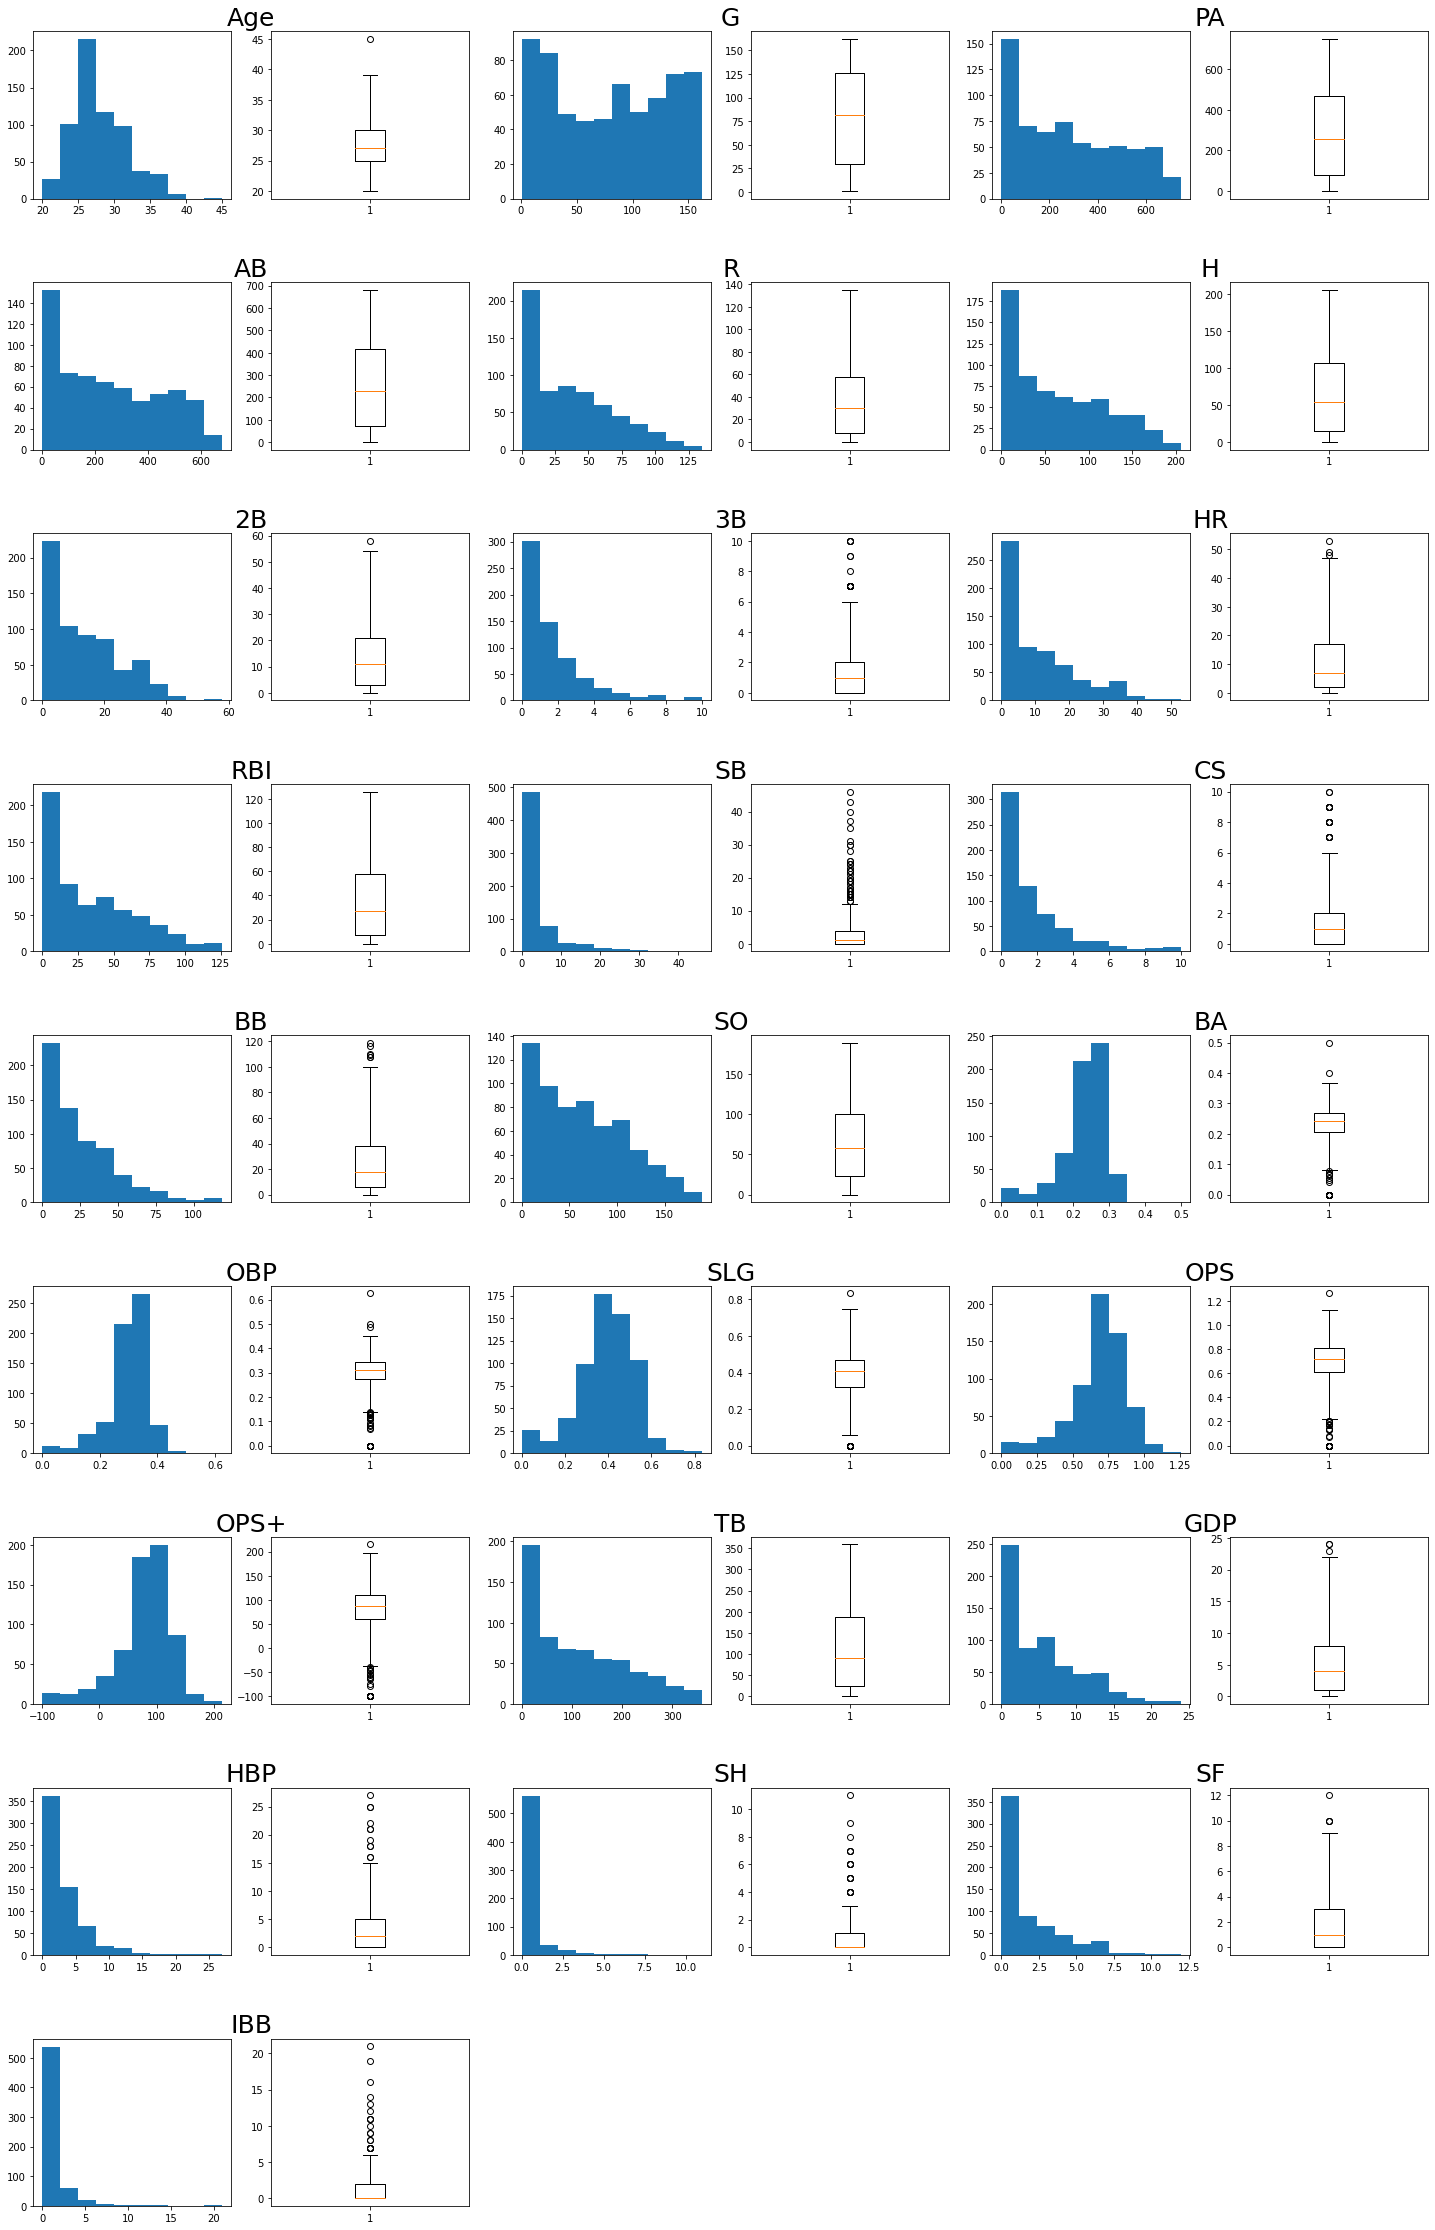

In [57]:
# Visualize the potential features using histograms and boxplots
fig = plt.figure(figsize=(25, 40))
outer = gridspec.GridSpec(9, 3, wspace=0.1, hspace=0.5)

for i, col in enumerate(X.columns[0:25]):
    inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                    subplot_spec=outer[i], wspace=0.2, hspace=0.2,)

    ax = plt.Subplot(fig, outer[i])
    ax.set_axis_off()
    ax.set_title(col, fontsize=25, fontweight=10)
    fig.add_subplot(ax)
    ax1 = plt.Subplot(fig, inner[0])
    ax1.hist(X.iloc[:,i])
    fig.add_subplot(ax1)
    ax2 = plt.Subplot(fig, inner[1])
    ax2.boxplot(X.iloc[:,i], whis=2)
    fig.add_subplot(ax2)

fig.show()

We note that very few of our variables are normally distributed. This is unsurprising for baseball statistics, especially when we consider that the data represents season totals, and there are many baseball players who only played a handful of games in 2019. The variables that are more closely normally distribute are 'Age', 'BA', 'OBP, 'SLG', 'OPS' and 'OPS+'. 'Age' makes sense because it is unaffected by how many games someone plays in a season. The other 5 make sense as well because they are based on averages, and are thus mostly unaffected by how many games someone plays.

The boxplots show us that many of our variables have outliers. For the season total data, this is actually a good thing. None of the outliers are so big/small that we suspect errors in the data. These outliers are just showing us players who are exceptionally good or bad with respect to the particular metric, which will actually assist us when it comes to clustering.

However, for the data that represents season averages, specifically 'BA', 'OBP, 'SLG', 'OPS' and 'OPS+', the outliers are the results of players with a small sample size of data, allowing them to have exceptionally high/low scores. Scores that would be unreasonable to expect from a player over a larger sample size. Because of this, we correct for the outliers by winsorizing the data to fix the bottom 5% and the upper 1%.

Afterwards, we'll examine how the variables are correlated to each other. Using a correlation matrix.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

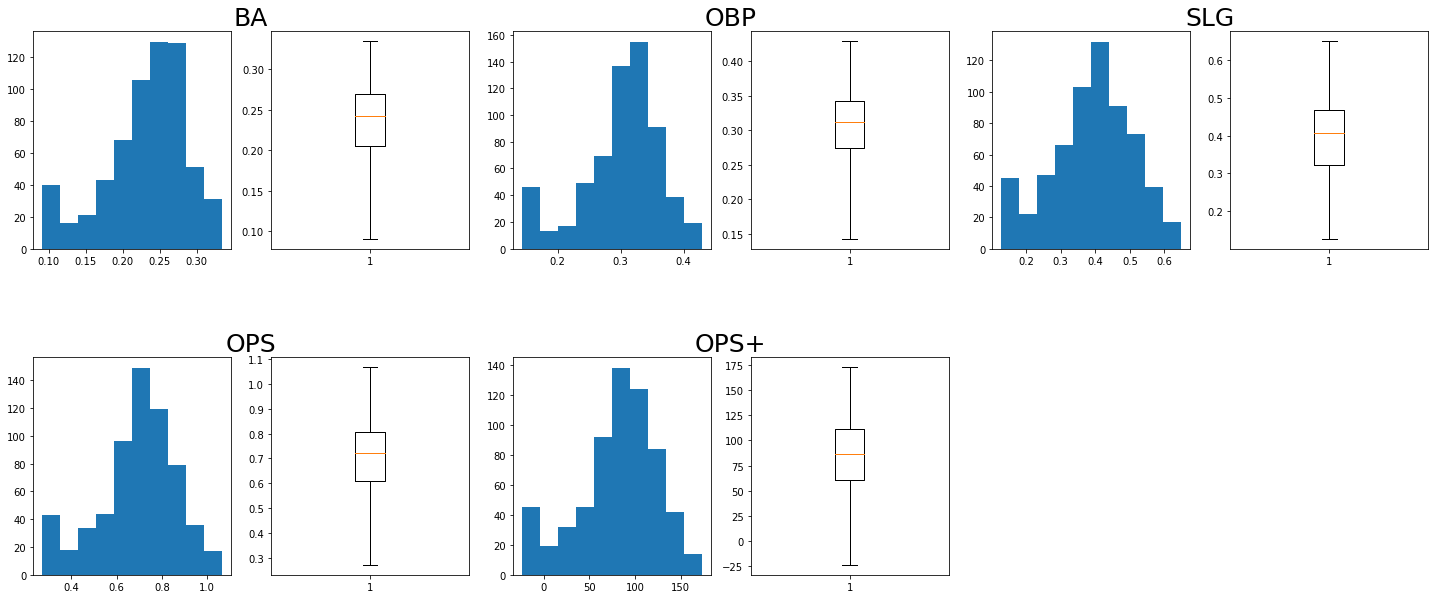

In [0]:
avg_cols = ['BA', 'OBP', 'SLG', 'OPS', 'OPS+']

# Visualize the potential features using histograms and boxplots
fig = plt.figure(figsize=(25, 10))
outer = gridspec.GridSpec(2, 3, wspace=0.1, hspace=0.5)

for i, col in enumerate(avg_cols):
    # apply winsorization
    X[col] = winsorize(X[col], limits=[0.05,0.01])

    inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                    subplot_spec=outer[i], wspace=0.2, hspace=0.2,)

    ax = plt.Subplot(fig, outer[i])
    ax.set_axis_off()
    ax.set_title(col, fontsize=25, fontweight=10)
    fig.add_subplot(ax)
    ax1 = plt.Subplot(fig, inner[0])
    ax1.hist(X.loc[:,col])
    fig.add_subplot(ax1)
    ax2 = plt.Subplot(fig, inner[1])
    ax2.boxplot(X.loc[:,col], whis=2)
    fig.add_subplot(ax2)

fig.show()

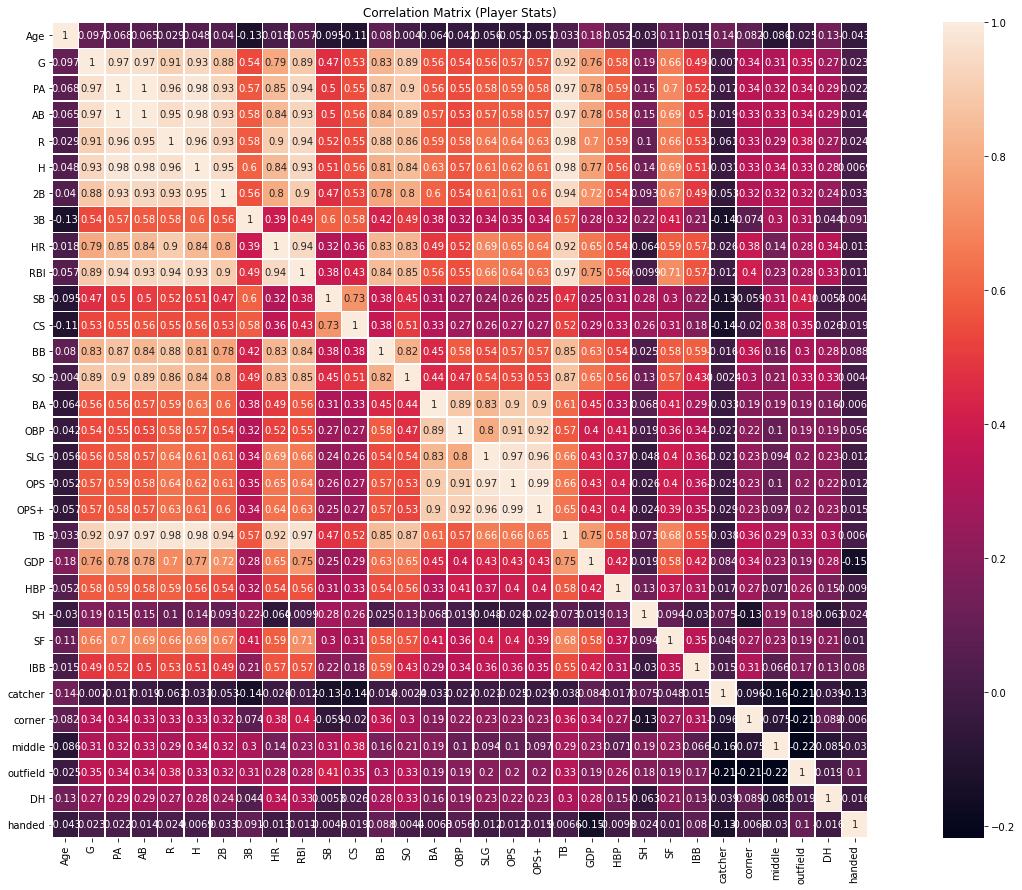

In [0]:
# make the correlation matrices.
corrmat = X.corr()

# heatmaps are a great way to get 
# a quick visual read on a big correlation matrix.

plt.figure(figsize=(27,15))

# draw the heatmap using seaborn.
sns.heatmap(corrmat, square=True, annot=True, linewidths=.5)
plt.title("Correlation Matrix (Player Stats)")

plt.show()

What we notice from this is that we have essentially two blocks of variables that are highly correlated to each other. The first block comprises 'G' the number of games a player played, as well as the vast majority of our data that is based on a season total, namely: 'PA', 'AB', 'R', 'H', '2B', 'HR', 'SB', 'BB', 'SO', and 'TB'. The other block we have is all of our average metrics such as 'BA', 'OBP', 'SLG', 'OPS', and 'OPS+'. In fact, 'OPS' and 'OPS+' are perfectly correlated, which makes sense because one is just a transformation of the other. Additionally, 'OPS' is simply the sum of 'OBP' and 'SLG', so the correlation is expected.

Here is what we are going to do:
- Since most Fantasy Baseball leagues only records points for 'R', 'HR', 'RBI', 'SB', 'BA' and 'TB', these are the statistics we'll narrow our search down to.
- With the exception of 'BA' these are all statistics that are highly correlated to how many games a player has appeared in. Therefore, we'll transform each into a per game ('PG') variable such as 'RPG' (runs per game). 
- Originally, I tried including positional data, since a player's position determines what roster spots he can occupy, and we want to make sure we have a balance of each. However, I found that the algorithms tended to cluster solely based on position, and mostly ignore a player's stats. So for now, we don't use positional data in the model, but I'd like to include it eventually.

In [0]:
# narrow down to fantasy relevant columns
X = X.iloc[:,[1, 4, 8, 9, 10, 14, 19]]
total_cols = ['R', 'HR', 'RBI', 'SB', 'TB']

# create per game statistics
for i, col in enumerate(total_cols):
  X[col + 'PG'] = X[col] / X['G']
X = X.drop(columns='G')
X.head()

,R,HR,RBI,SB,BA,TB,RPG,HRPG,RBIPG,SBPG,TBPG
1,85,33,123,2,0.284,319,0.534591,0.207547,0.773585,0.012579,2.006289
2,127,41,101,37,0.280,324,0.814103,0.262821,0.647436,0.237179,2.076923
4,1,0,2,0,0.318,8,0.100000,0.000000,0.200000,0.000000,0.800000
5,69,20,52,4,0.254,222,0.453947,0.131579,0.342105,0.026316,1.460526
8,42,20,56,0,0.226,144,0.378378,0.180180,0.504505,0.000000,1.297297


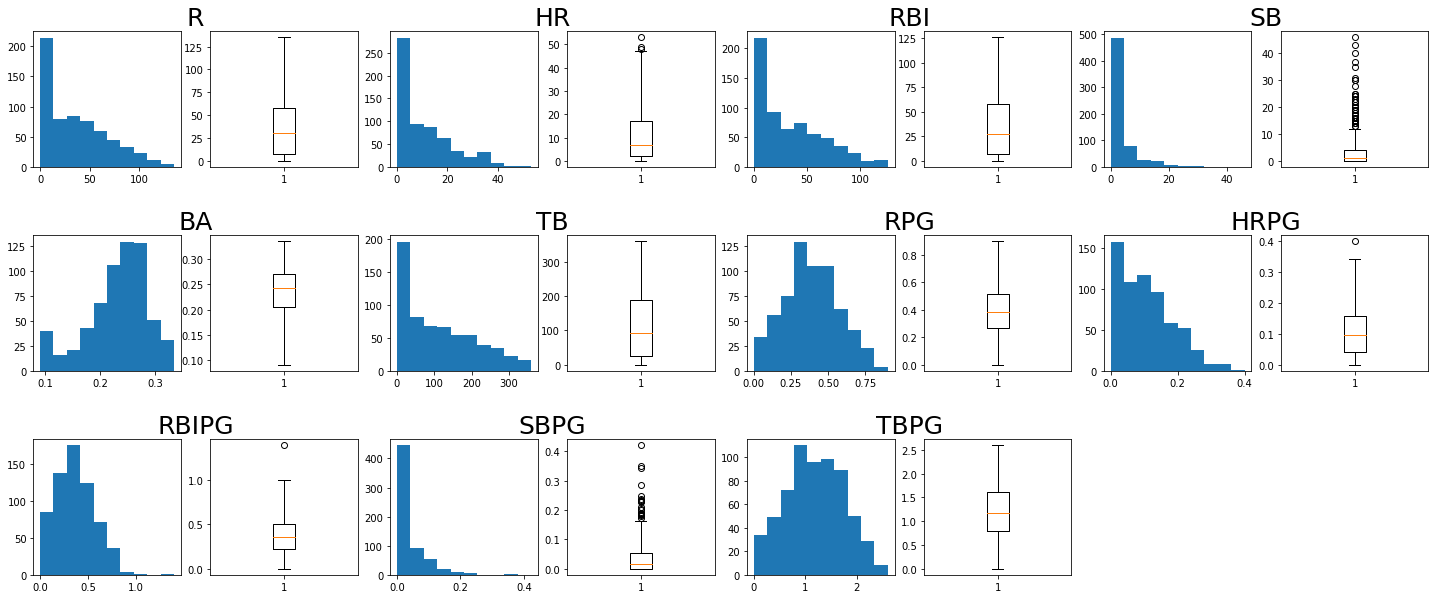

In [0]:
# Visualize the potential features using histograms and boxplots
fig = plt.figure(figsize=(25, 10))
outer = gridspec.GridSpec(3, 4, wspace=0.1, hspace=0.5)

for i, col in enumerate(X.columns):
    inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                    subplot_spec=outer[i], wspace=0.2, hspace=0.2,)

    ax = plt.Subplot(fig, outer[i])
    ax.set_axis_off()
    ax.set_title(col, fontsize=25, fontweight=10)
    fig.add_subplot(ax)
    ax1 = plt.Subplot(fig, inner[0])
    ax1.hist(X.iloc[:,i])
    fig.add_subplot(ax1)
    ax2 = plt.Subplot(fig, inner[1])
    ax2.boxplot(X.iloc[:,i], whis=2)
    fig.add_subplot(ax2)

fig.show()

We note that our per game statistics, with the exception of stolen bases and home runs, are much more normal approximating that their respective season totals. However, some of the per game statistics include upper values that don't line up with what we'd expect from someone playing a significant number of games. This is due to a handful of players who have high averages due to a small sample of plate appearances. We'll fix this by replacing any per game statistic that is higher than the maximum among players who played at least 81 games (half a season) with that maximum value.

In [0]:
pg_cols = ['RPG', 'HRPG', 'RBIPG', 'SBPG', 'TBPG']
for col in pg_cols:
  # define maximum
  limit = X.loc[player_stats['G'] >= 81][col].max()
  for i in X.index:
    # replace value with maximum if it exceeds limit
    if X.loc[i,col] > limit:
      X.loc[i,col] = limit

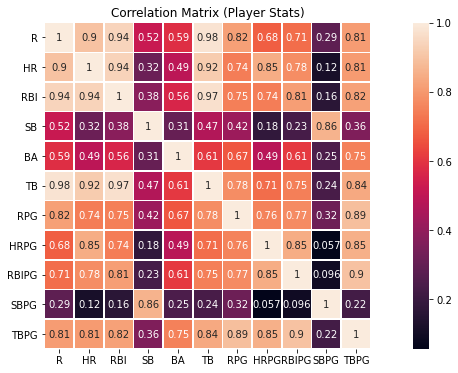

In [0]:
# make the correlation matrices.
corrmat = X.corr()

# heatmaps are a great way to get 
# a quick visual read on a big correlation matrix.

plt.figure(figsize=(15,6))

# draw the heatmap using seaborn.
sns.heatmap(corrmat, square=True, annot=True, linewidths=.5)
plt.title("Correlation Matrix (Player Stats)")

plt.show()

The transformation into per game statistics has mitigated the high correlation somewhat. We also see that the distributions of the variables has balanced out as a result. We move forward into dimensionality reduction with these 11 variables.

#Dimensionality Reduction

We'll examine dimensionality reduction and visualization using PCA, t-SNE, and UMAP. Each method will be evaluated by running k-means on the resulting 2-D representation and examining the silhouette coefficient. We somewhat choose k=10 for this evaluation.

##PCA

In [0]:
# we normalize our data by making each feature range from 0 to 1
X_std = pd.DataFrame()
for col in X.columns:
  X_std[col] = (X[col] - X[col].min()) / (X[col].max() - X[col].min())

In [0]:
# We just want the first two principal components
pca = PCA(n_components=2)

# We get the components by 
# calling fit_transform method with our data
pca_components = pca.fit_transform(X_std)

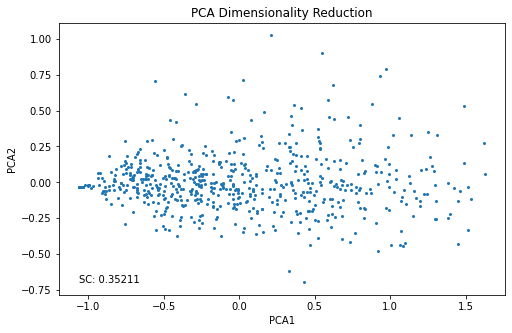

In [0]:
# plot 2-D visualization of data
plt.figure(figsize=(8,5))
plt.scatter(pca_components[:, 0], pca_components[:, 1], s=4)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
labels = KMeans(n_clusters=10, random_state=123).fit_predict(pca_components[:,[0,1]])

# include silhouette coefficient in the visualization
silco = metrics.silhouette_score(pca_components[:,[0,1]], labels, metric='euclidean')
plt.text(pca_components[:,0].min(),
         pca_components[:,1].min(),
         s='SC: {:.5f}'.format(silco))
plt.title("PCA Dimensionality Reduction")
plt.show()

##t-SNE

In [0]:
# we generate a df of t-SNE components using perplexities from 5-50
tsne_components = pd.DataFrame()
perplexities = np.arange(5,52.5,2.5)
for i, perplexity in enumerate(perplexities):
  tsne = TSNE(n_components=2, verbose=1,
              perplexity=perplexity, n_iter=300,
              random_state=1247)
  tsne_results = tsne.fit_transform(X_std)
  tsne_components[2*i] = tsne_results[:,0]
  tsne_components[2*i+1] = tsne_results[:,1]

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 635 samples in 0.001s...
[t-SNE] Computed neighbors for 635 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 635 / 635
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.690170
[t-SNE] KL divergence after 300 iterations: 1.361754
[t-SNE] Computing 23 nearest neighbors...
[t-SNE] Indexed 635 samples in 0.001s...
[t-SNE] Computed neighbors for 635 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 635 / 635
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.746864
[t-SNE] KL divergence after 300 iterations: 1.262198
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 635 samples in 0.001s...
[t-SNE] Computed neighbors for 635 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 635 / 635
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations

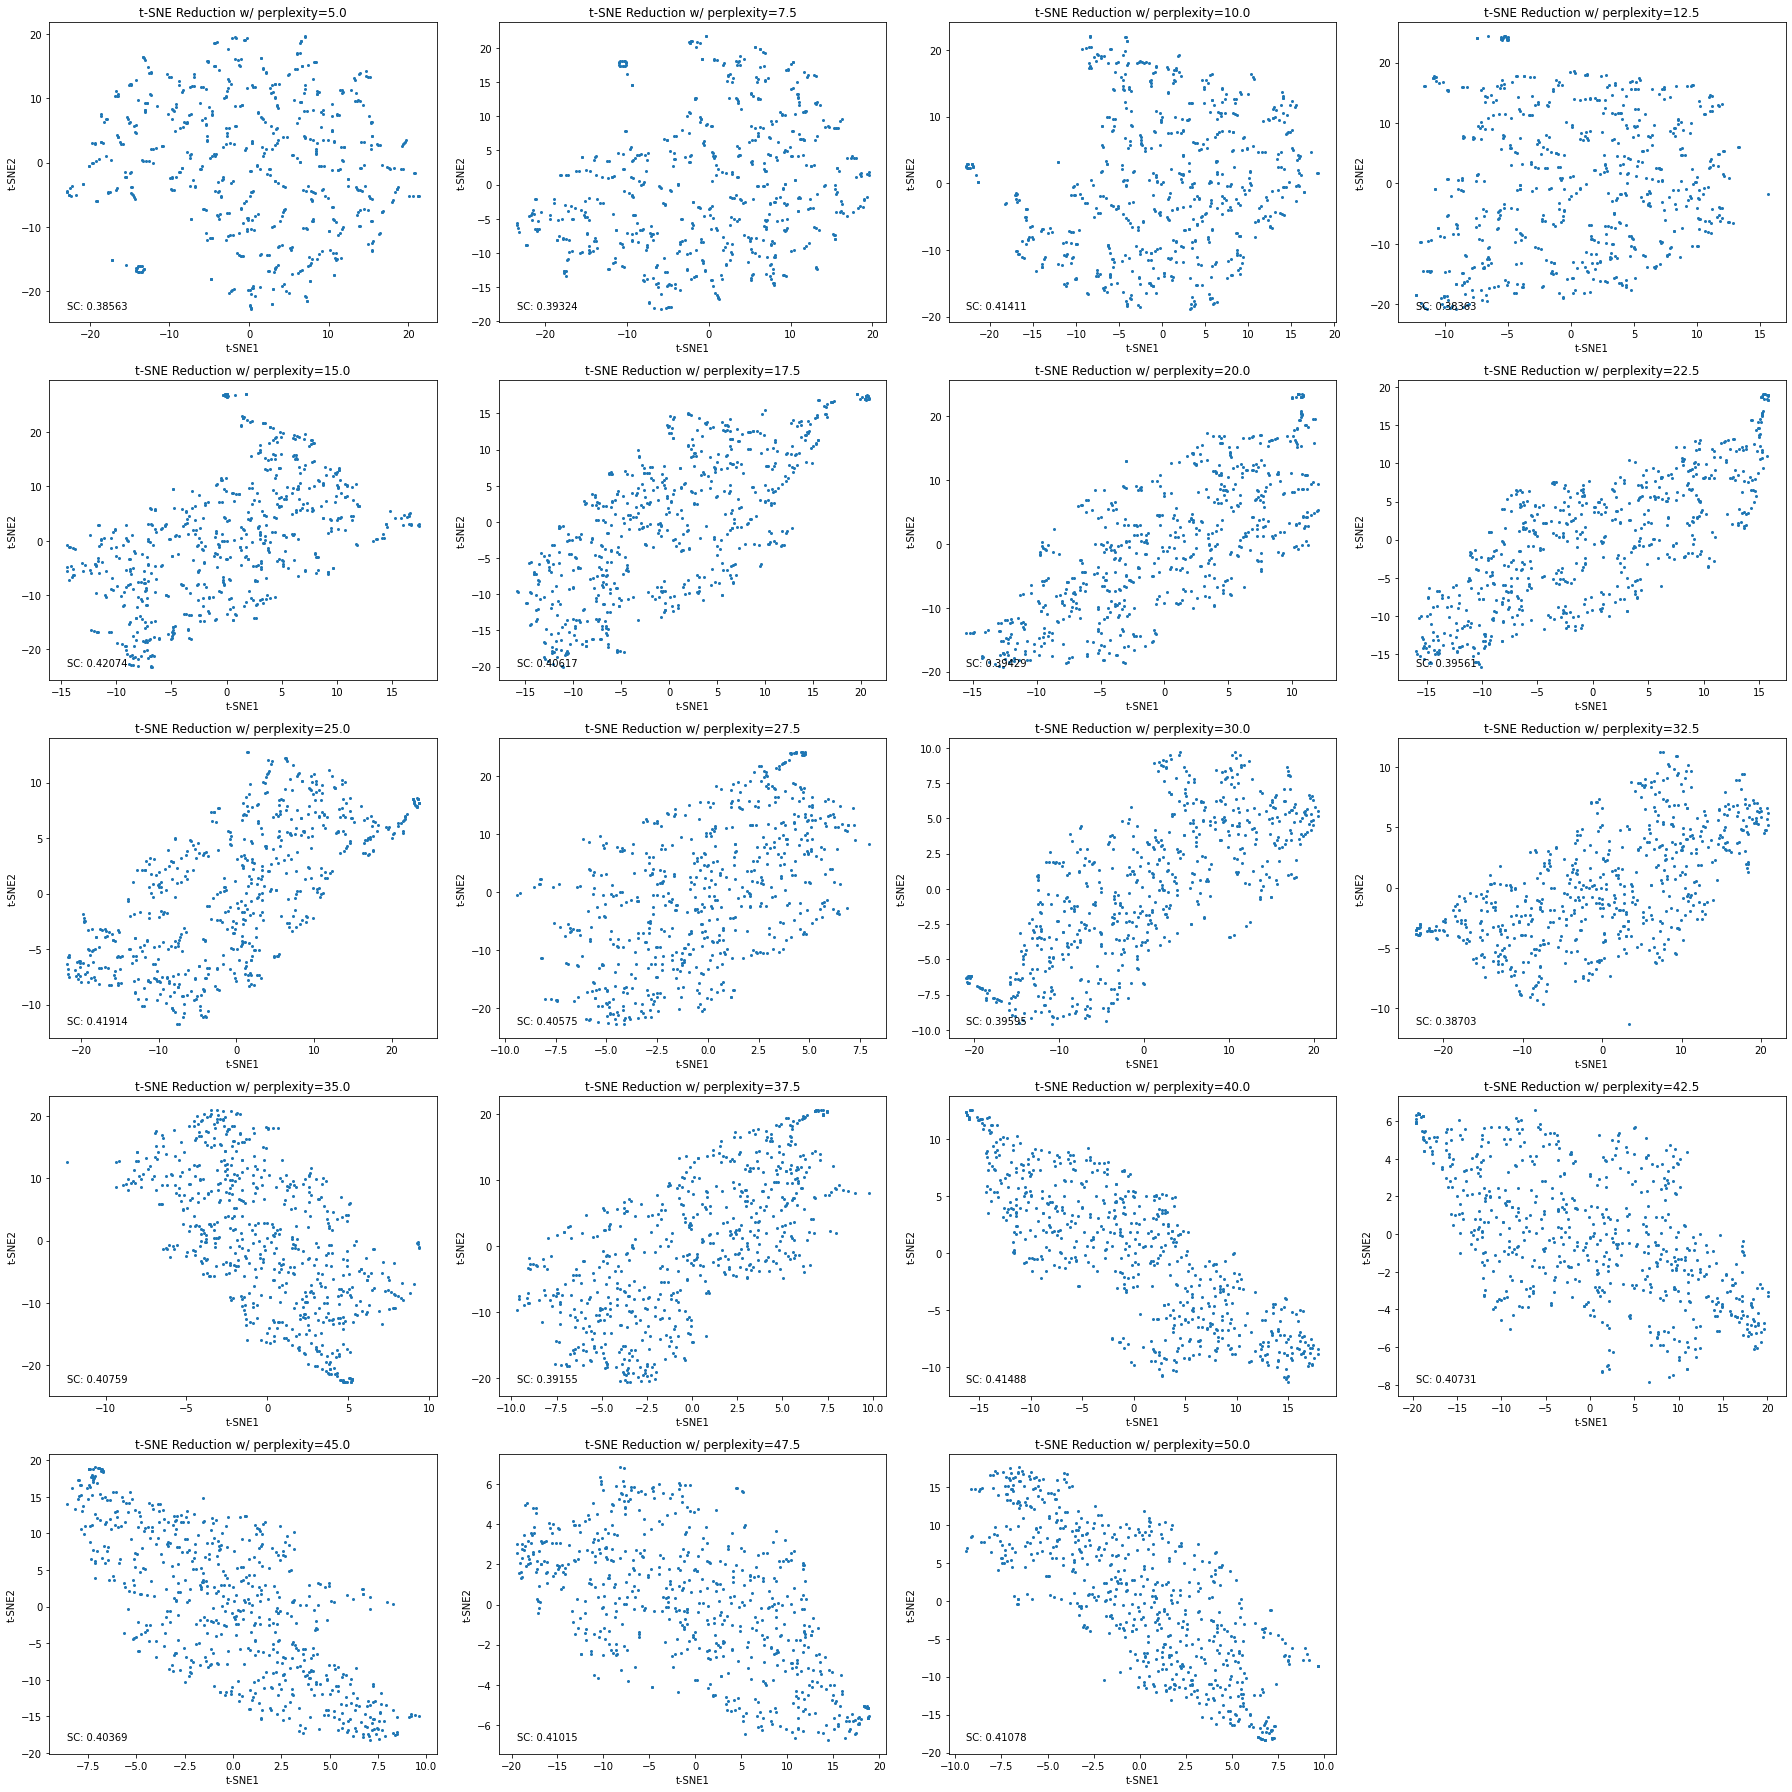

In [0]:
plt.figure(figsize=(25,25))
tsne_silcos = []
for i in range(int(tsne_components.shape[1]/2)):
  # plot 2-D visualization of data
  plt.subplot(5,4,i+1)
  plt.scatter(tsne_components.iloc[:, 2*i], tsne_components.iloc[:, 2*i+1], s=4)
  plt.xlabel('t-SNE1')
  plt.ylabel('t-SNE2')
  tsne_labels = KMeans(n_clusters=10, random_state=123).fit_predict(tsne_components.iloc[:,[2*i,2*i+1]])
  silco = metrics.silhouette_score(tsne_components.iloc[:,[2*i,2*i+1]], tsne_labels, metric='euclidean')
  tsne_silcos.append(silco)
  plt.title('t-SNE Reduction w/ perplexity={}'.format(perplexities[i]))
  plt.text(tsne_components.iloc[:,2*i].min(),
          tsne_components.iloc[:,2*i+1].min(),
          s='SC: {:.5f}'.format(silco))
plt.tight_layout()
plt.show()

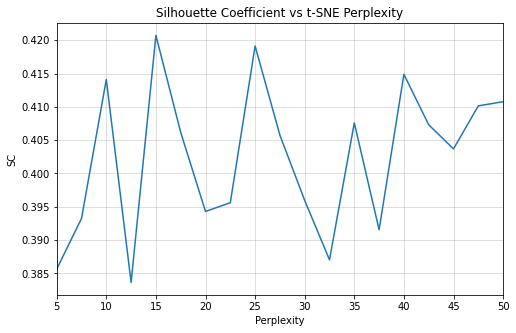

In [0]:
# plot SC vs t-SNE perplexity
plt.figure(figsize=(8,5))
plt.plot(perplexities,tsne_silcos)
plt.title("Silhouette Coefficient vs t-SNE Perplexity")
plt.xlim(perplexities.min(),perplexities.max())
plt.xlabel('Perplexity')
plt.ylabel('SC')
plt.grid(alpha=0.5)
plt.show()

##UMAP

In [0]:
# we generate a df of UMAP components using a range of n_neighbors from 3-5
# and a range of min_dist from 0.01-0.10
umap_components = pd.DataFrame()
num_neighbors = np.arange(3,6)
distances = np.arange(0.01,0.11,0.01)
j = 0

for n in num_neighbors:
  for dist in distances:
    umapper = umap.UMAP(n_neighbors=n,
                        min_dist=dist,
                        metric='correlation',
                        random_state=1247)
    umap_results = umapper.fit_transform(X_std)
    umap_components[j] = umap_results[:,0]
    umap_components[j+1] = umap_results[:,1]
    j = j + 2

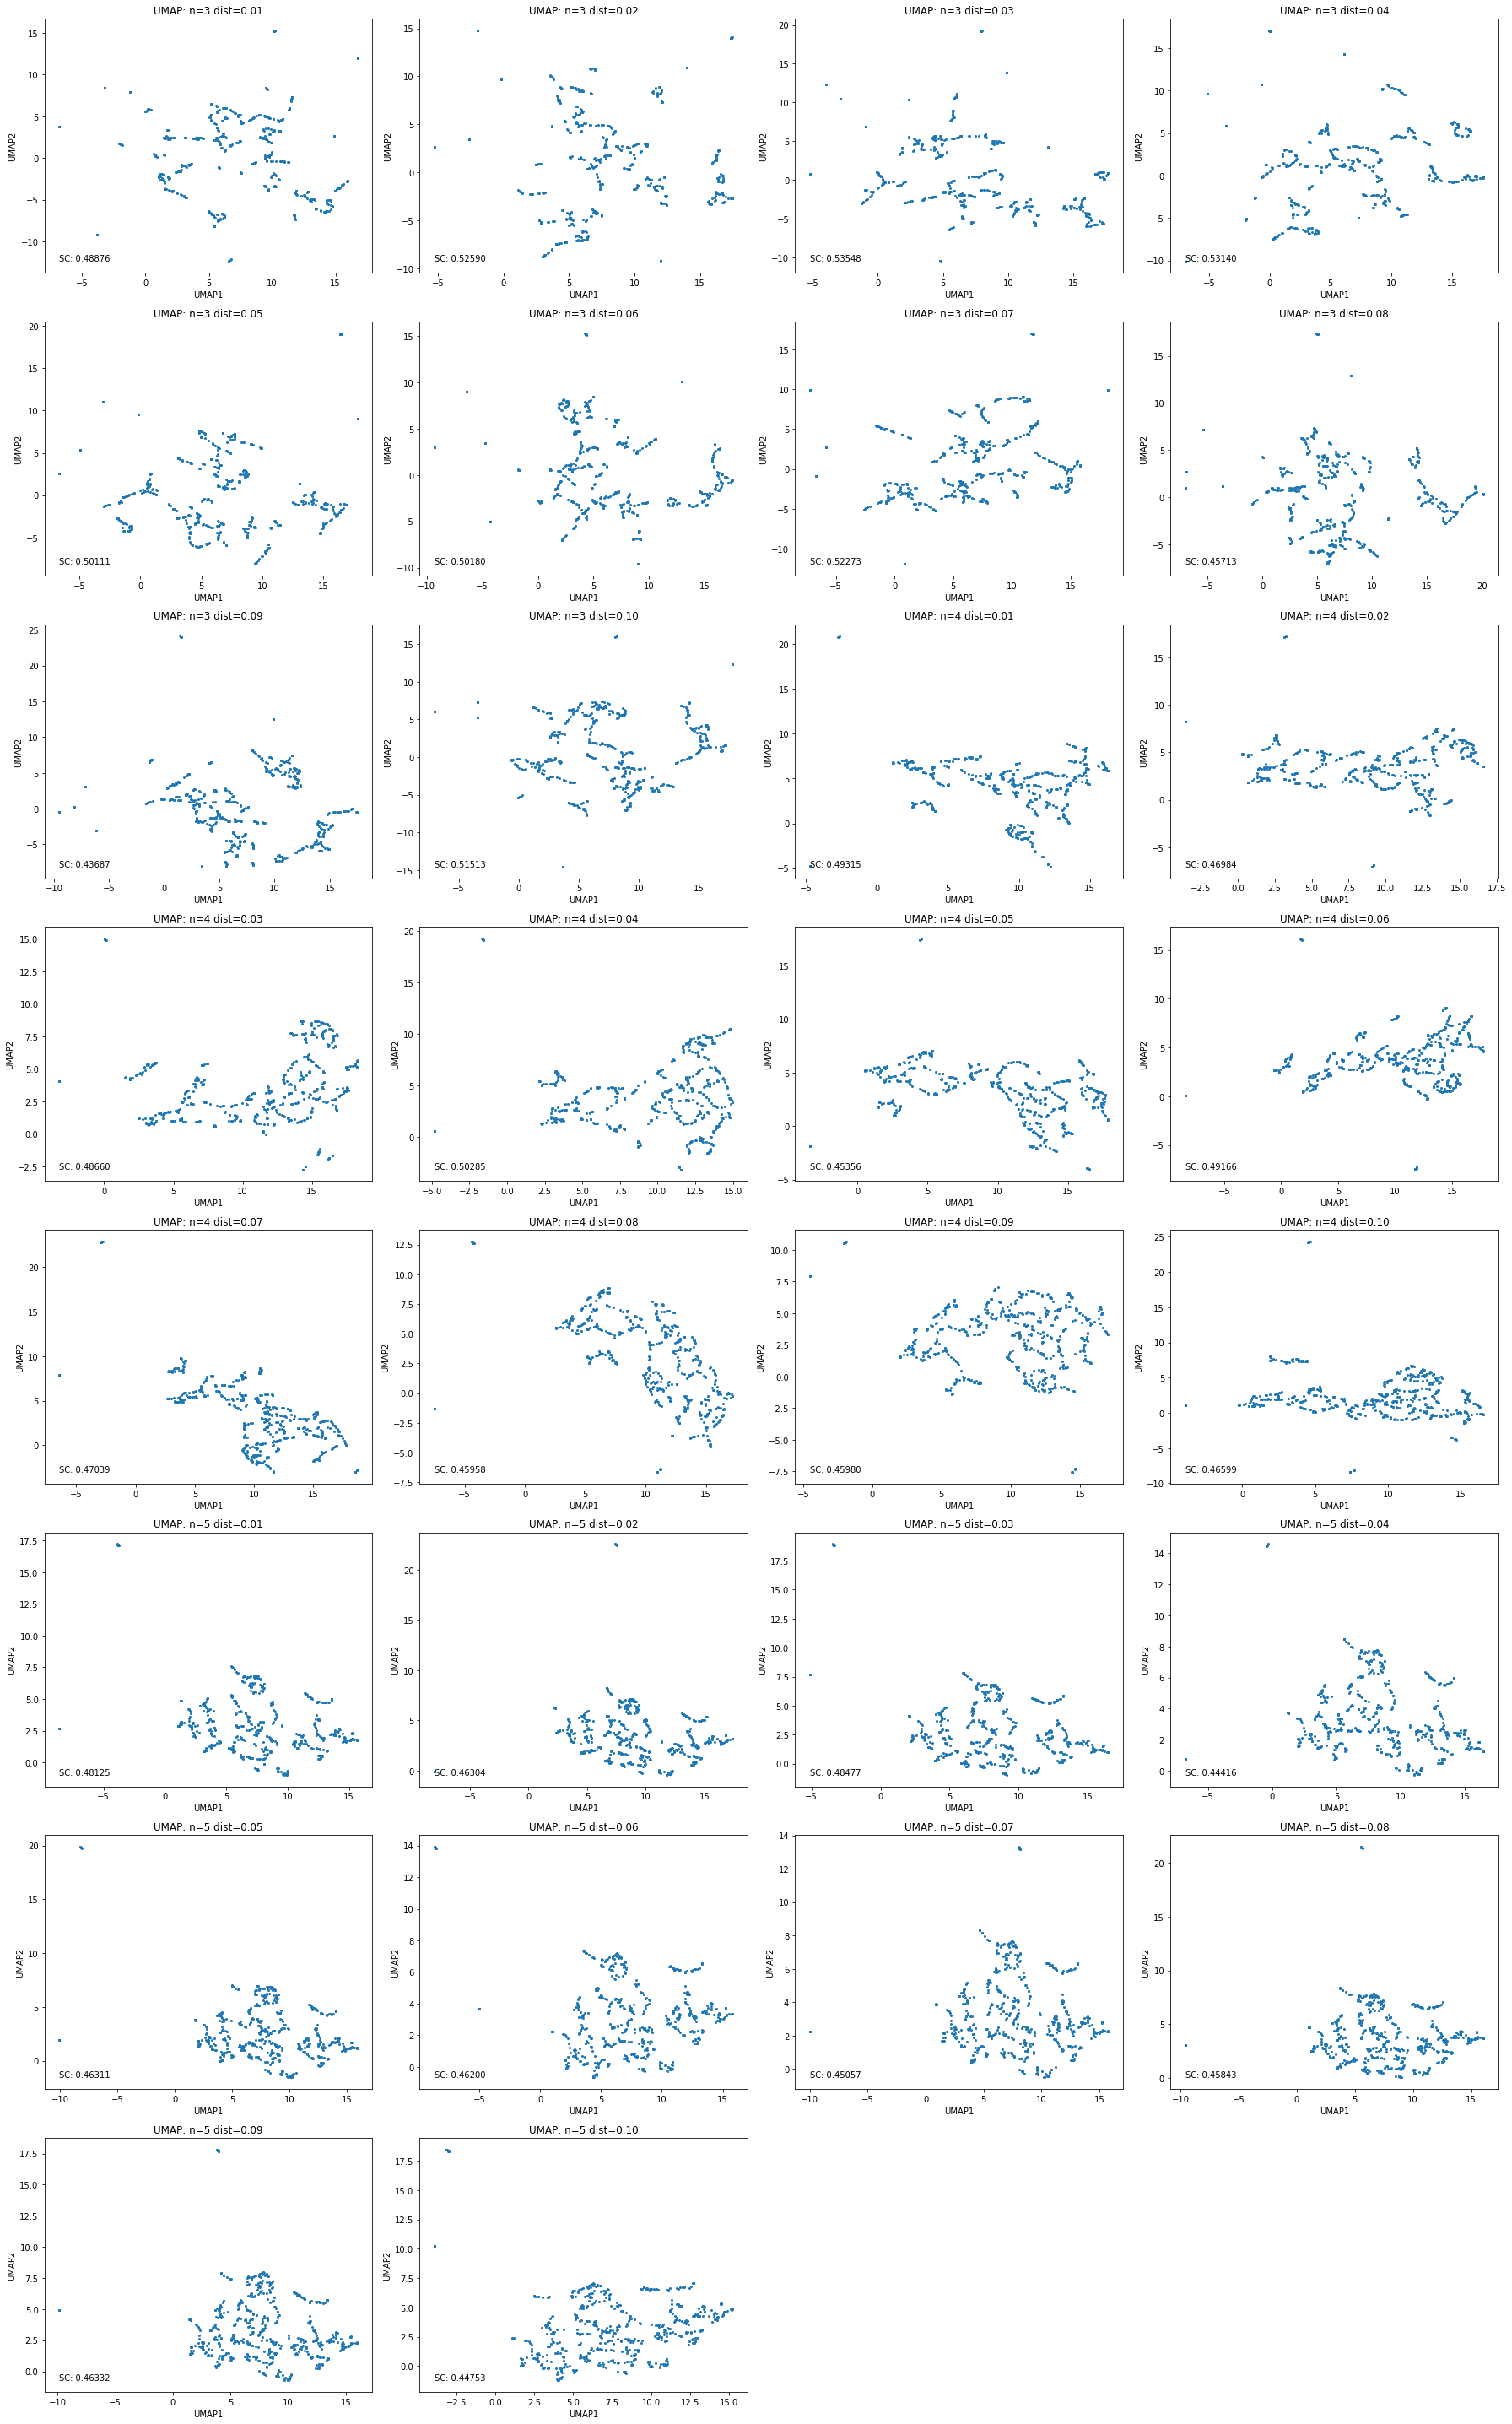

In [0]:
plt.figure(figsize=(25,40))
umap_silcos = []
for i in range(int(umap_components.shape[1]/2)):
  # plot 2-D visualization of data
  n = num_neighbors[int(i/len(distances))]
  dist = distances[i % len(distances)]
  plt.subplot(8,4,i+1)
  plt.scatter(umap_components.iloc[:, 2*i], umap_components.iloc[:, 2*i+1], s=4)
  plt.xlabel('UMAP1')
  plt.ylabel('UMAP2')

  # include SC on the plot
  umap_labels = KMeans(n_clusters=10, random_state=123).fit_predict(umap_components.iloc[:,[2*i,2*i+1]])
  silco = metrics.silhouette_score(umap_components.iloc[:,[2*i,2*i+1]],
                                   umap_labels,
                                   metric='euclidean')
  umap_silcos.append(silco)
  plt.title('UMAP: n={} dist={:.2f}'.format(n,dist))
  plt.text(umap_components.iloc[:,2*i].min(),
          umap_components.iloc[:,2*i+1].min(),
          s='SC: {:.5f}'.format(silco))
plt.tight_layout()
plt.show()

##Discussion of Dimensionality Reduction

Below we have the highest observed Silhouette Coefficients for each dimensionality-reduction method when clustered using K-means and k=10.

Method |   SC   | Hyperparameters
-------|--------|------------
PCA    | 0.35211|      n/a
t-SNE  | 0.42074| perplexity=15
UMAP   | 0.53548| n_neighbors=3, min_dist=0.03

As we can see from the silhouette scores, as well as the 2-D visualizations, UMAP provided the most easily distinguishable clusters. We'll move forward using the components achieved from this method as our low-dimensional representation of the features.

In [0]:
# Store ideal low-dimensional components
X_umap = umap_components.iloc[:,[4,5]]

#Clustering

We try clustering the dimensionality-reduced data using K-means, Agglomeration, and DBSCAN, tuning each for the ideal settings to yield the highest Silhouette Coefficient.

##K-means

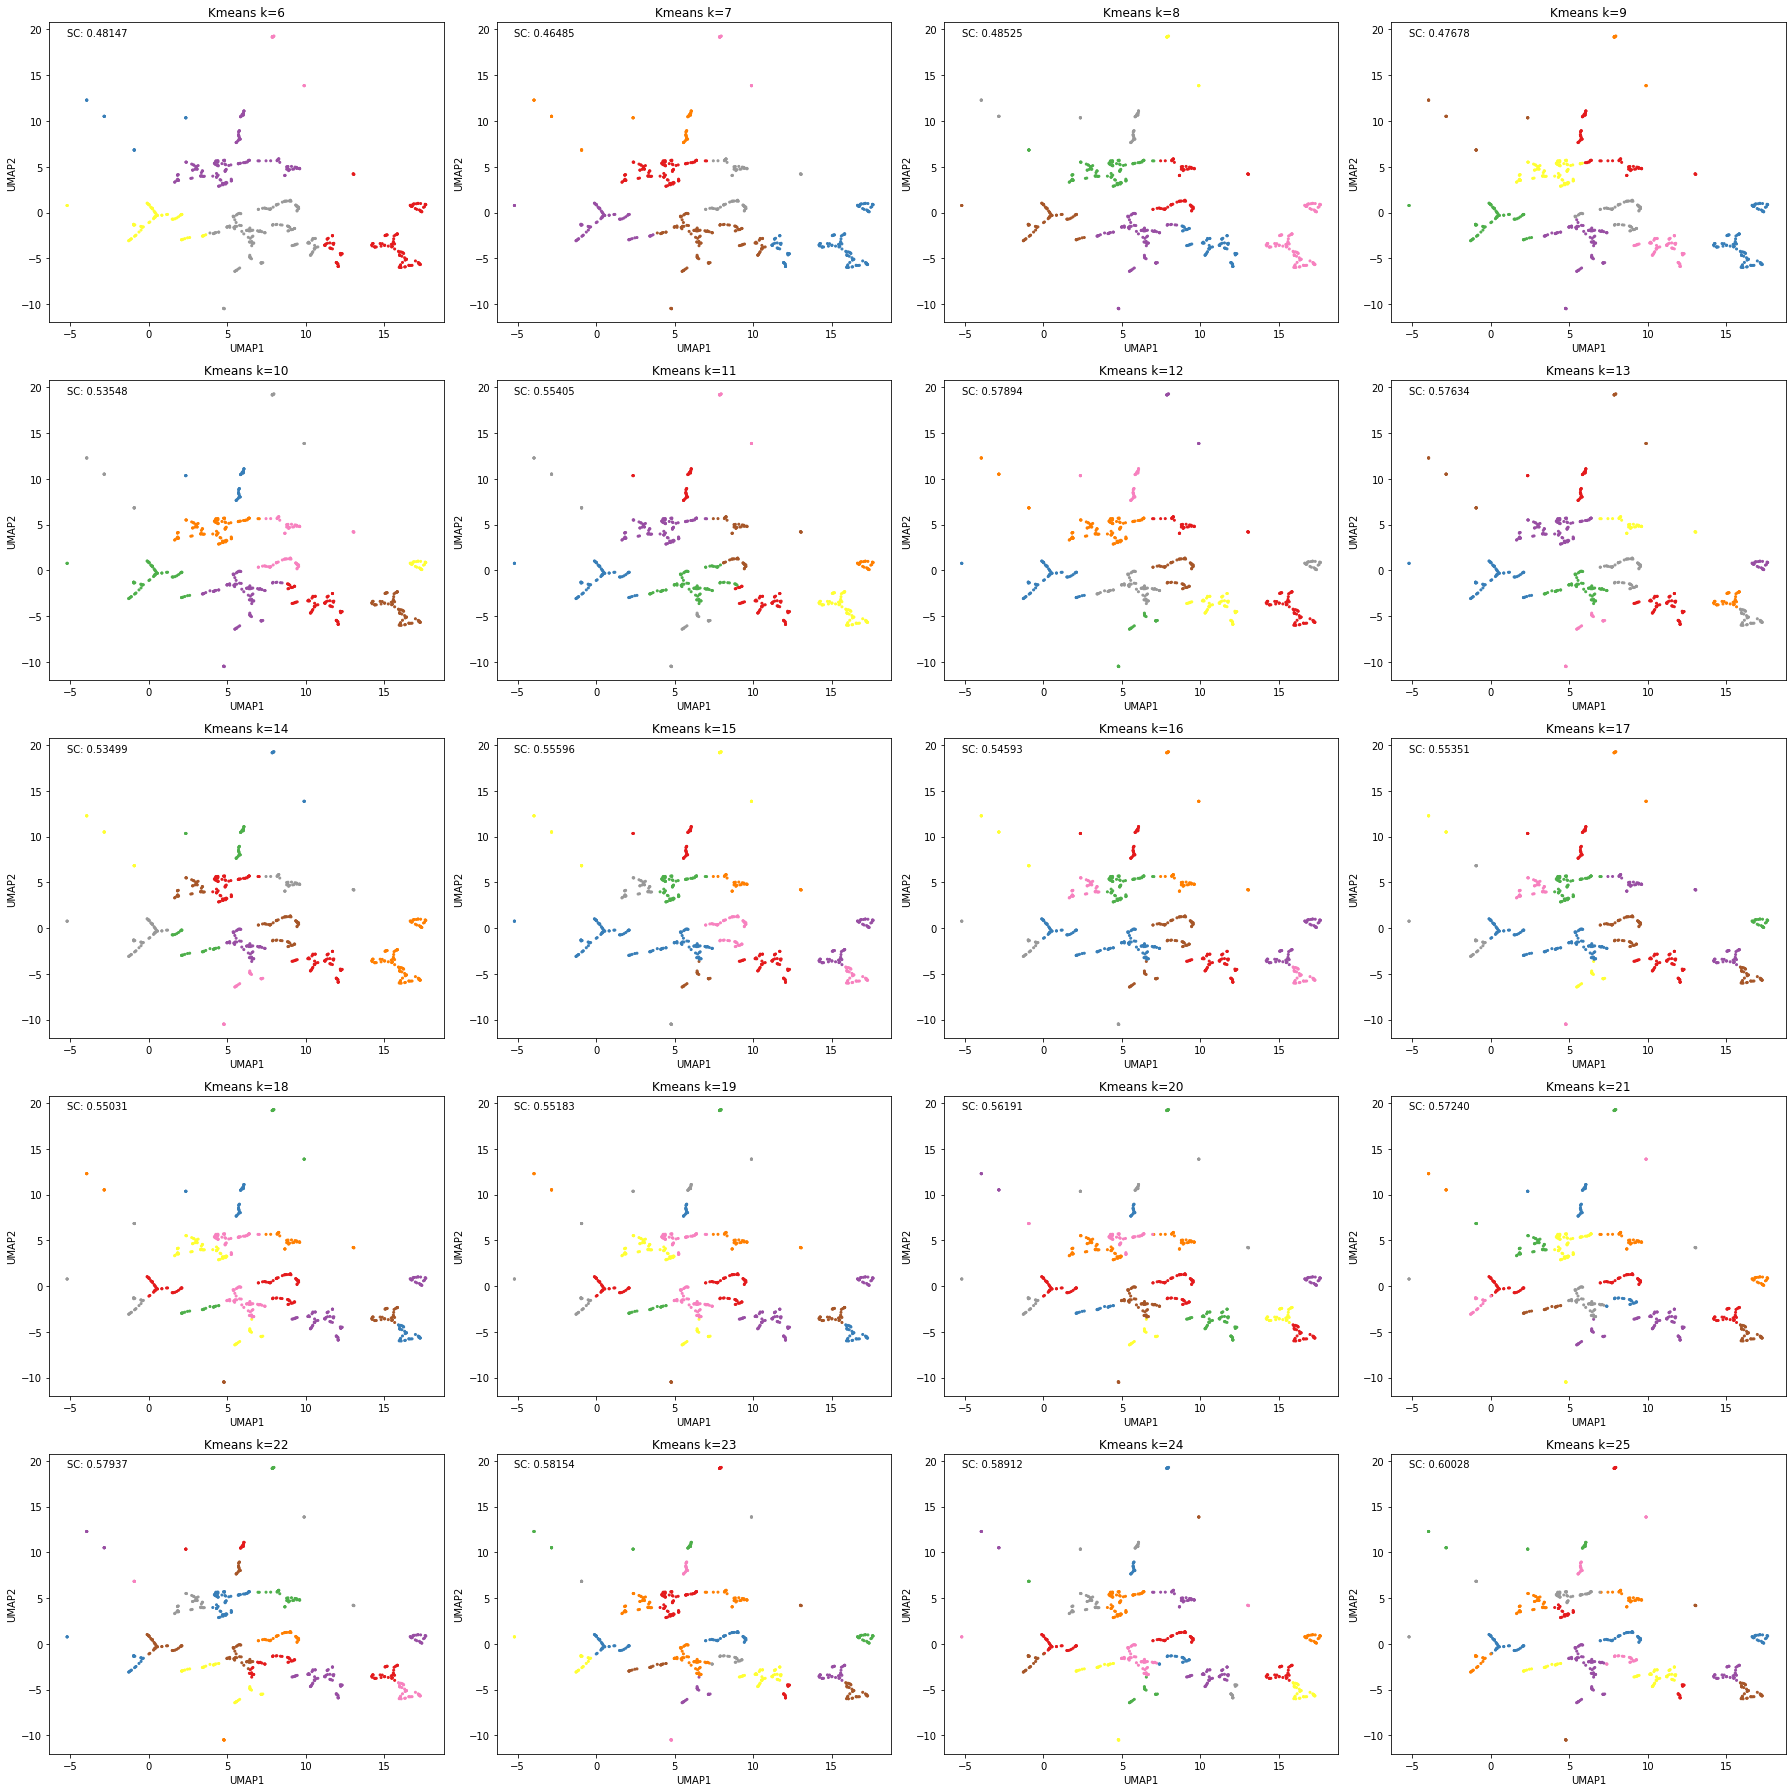

In [0]:
plt.figure(figsize=(25,25))
for k in range(6,26):
  # Defining the clustering
  kmeans_cluster = KMeans(n_clusters=k, random_state=123)

  # Fit model & calculate silhouette coefficient
  kmeans_labels = kmeans_cluster.fit_predict(X_umap)
  silco = metrics.silhouette_score(X_umap, kmeans_labels, metric='euclidean')
  
  # Plot the clusters
  plt.subplot(5,4,k-5)
  plt.scatter(X_umap.iloc[:,0], X_umap.iloc[:,1], c=kmeans_labels, s=4, cmap='Set1')
  plt.title("Kmeans k={}".format(k))
  plt.xlabel('UMAP1')
  plt.ylabel('UMAP2')
  plt.text(X_umap.iloc[:,0].min(),
           X_umap.iloc[:,1].max(),
           s='SC: {:.5f}'.format(silco))
plt.tight_layout()
plt.show()

##Agglomeration

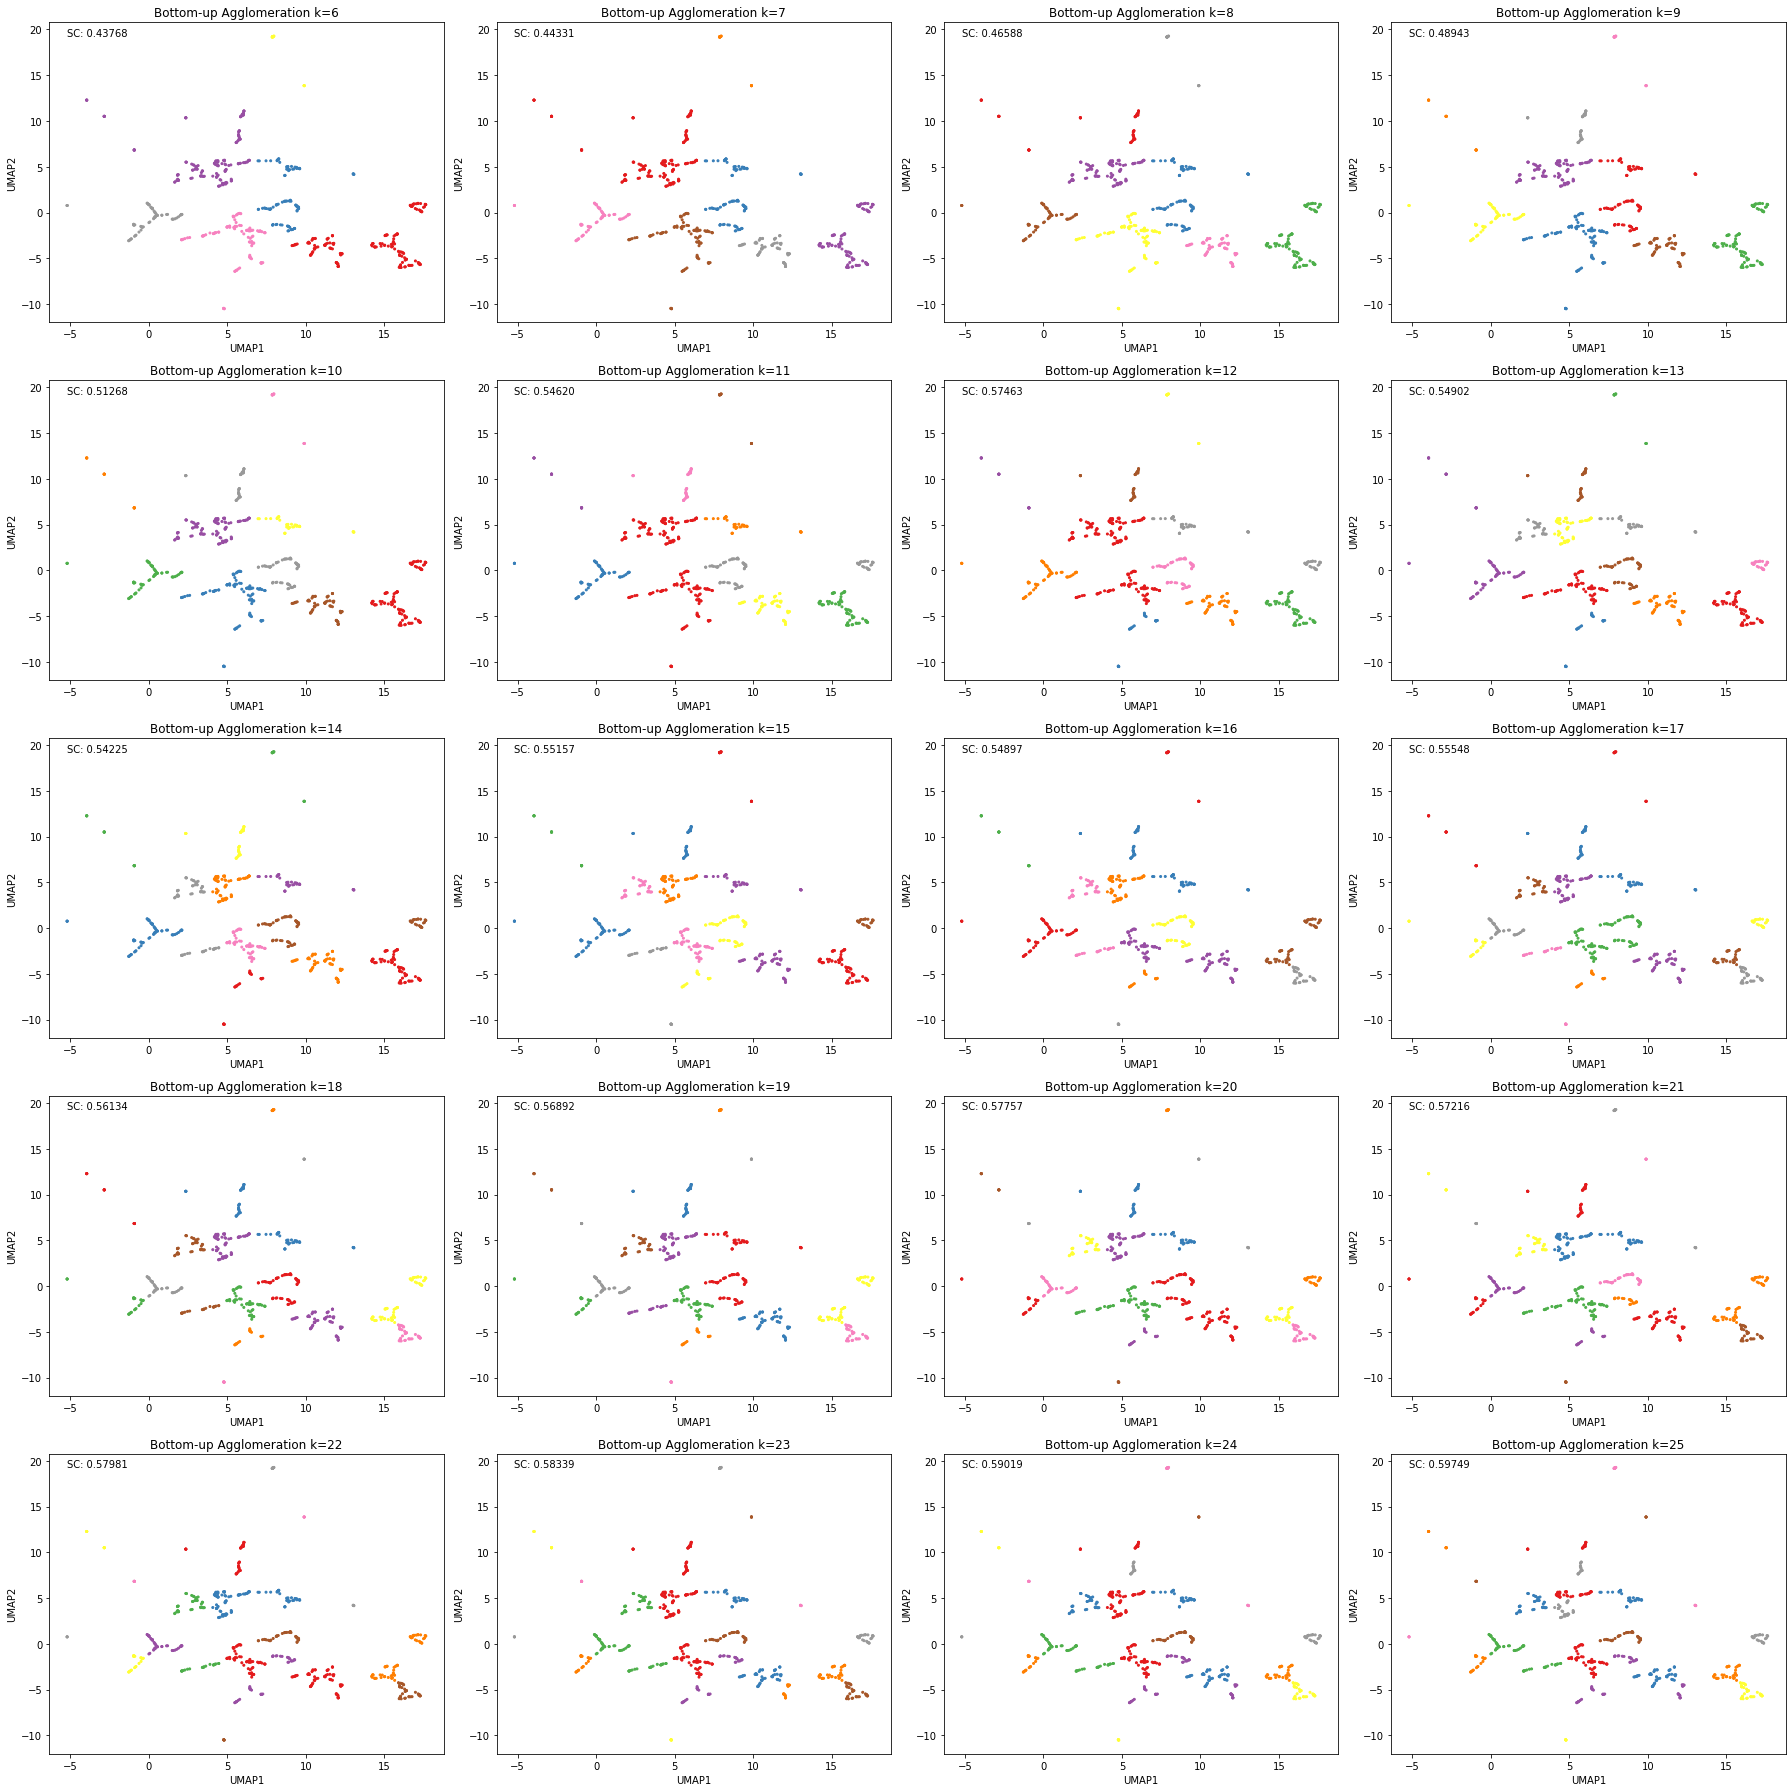

In [0]:
plt.figure(figsize=(25,25))
for k in range(6,26):
  # Defining the clustering
  agg_cluster = AgglomerativeClustering(linkage='ward',
                                        affinity='euclidean',
                                        n_clusters=k)
  
  # Fit model & calculate silhouette coefficient
  agg_labels = agg_cluster.fit_predict(X_umap)
  silco = metrics.silhouette_score(X_umap, agg_labels, metric='euclidean')
  
  # Plot the clusters
  plt.subplot(5,4,k-5)
  plt.scatter(X_umap.iloc[:,0], X_umap.iloc[:,1], c=agg_labels, s=4, cmap='Set1')
  plt.title("Bottom-up Agglomeration k={}".format(k))
  plt.xlabel('UMAP1')
  plt.ylabel('UMAP2')
  plt.text(X_umap.iloc[:,0].min(),
           X_umap.iloc[:,1].max(),
           s='SC: {:.5f}'.format(silco))
plt.tight_layout()
plt.show()

##DBSCAN

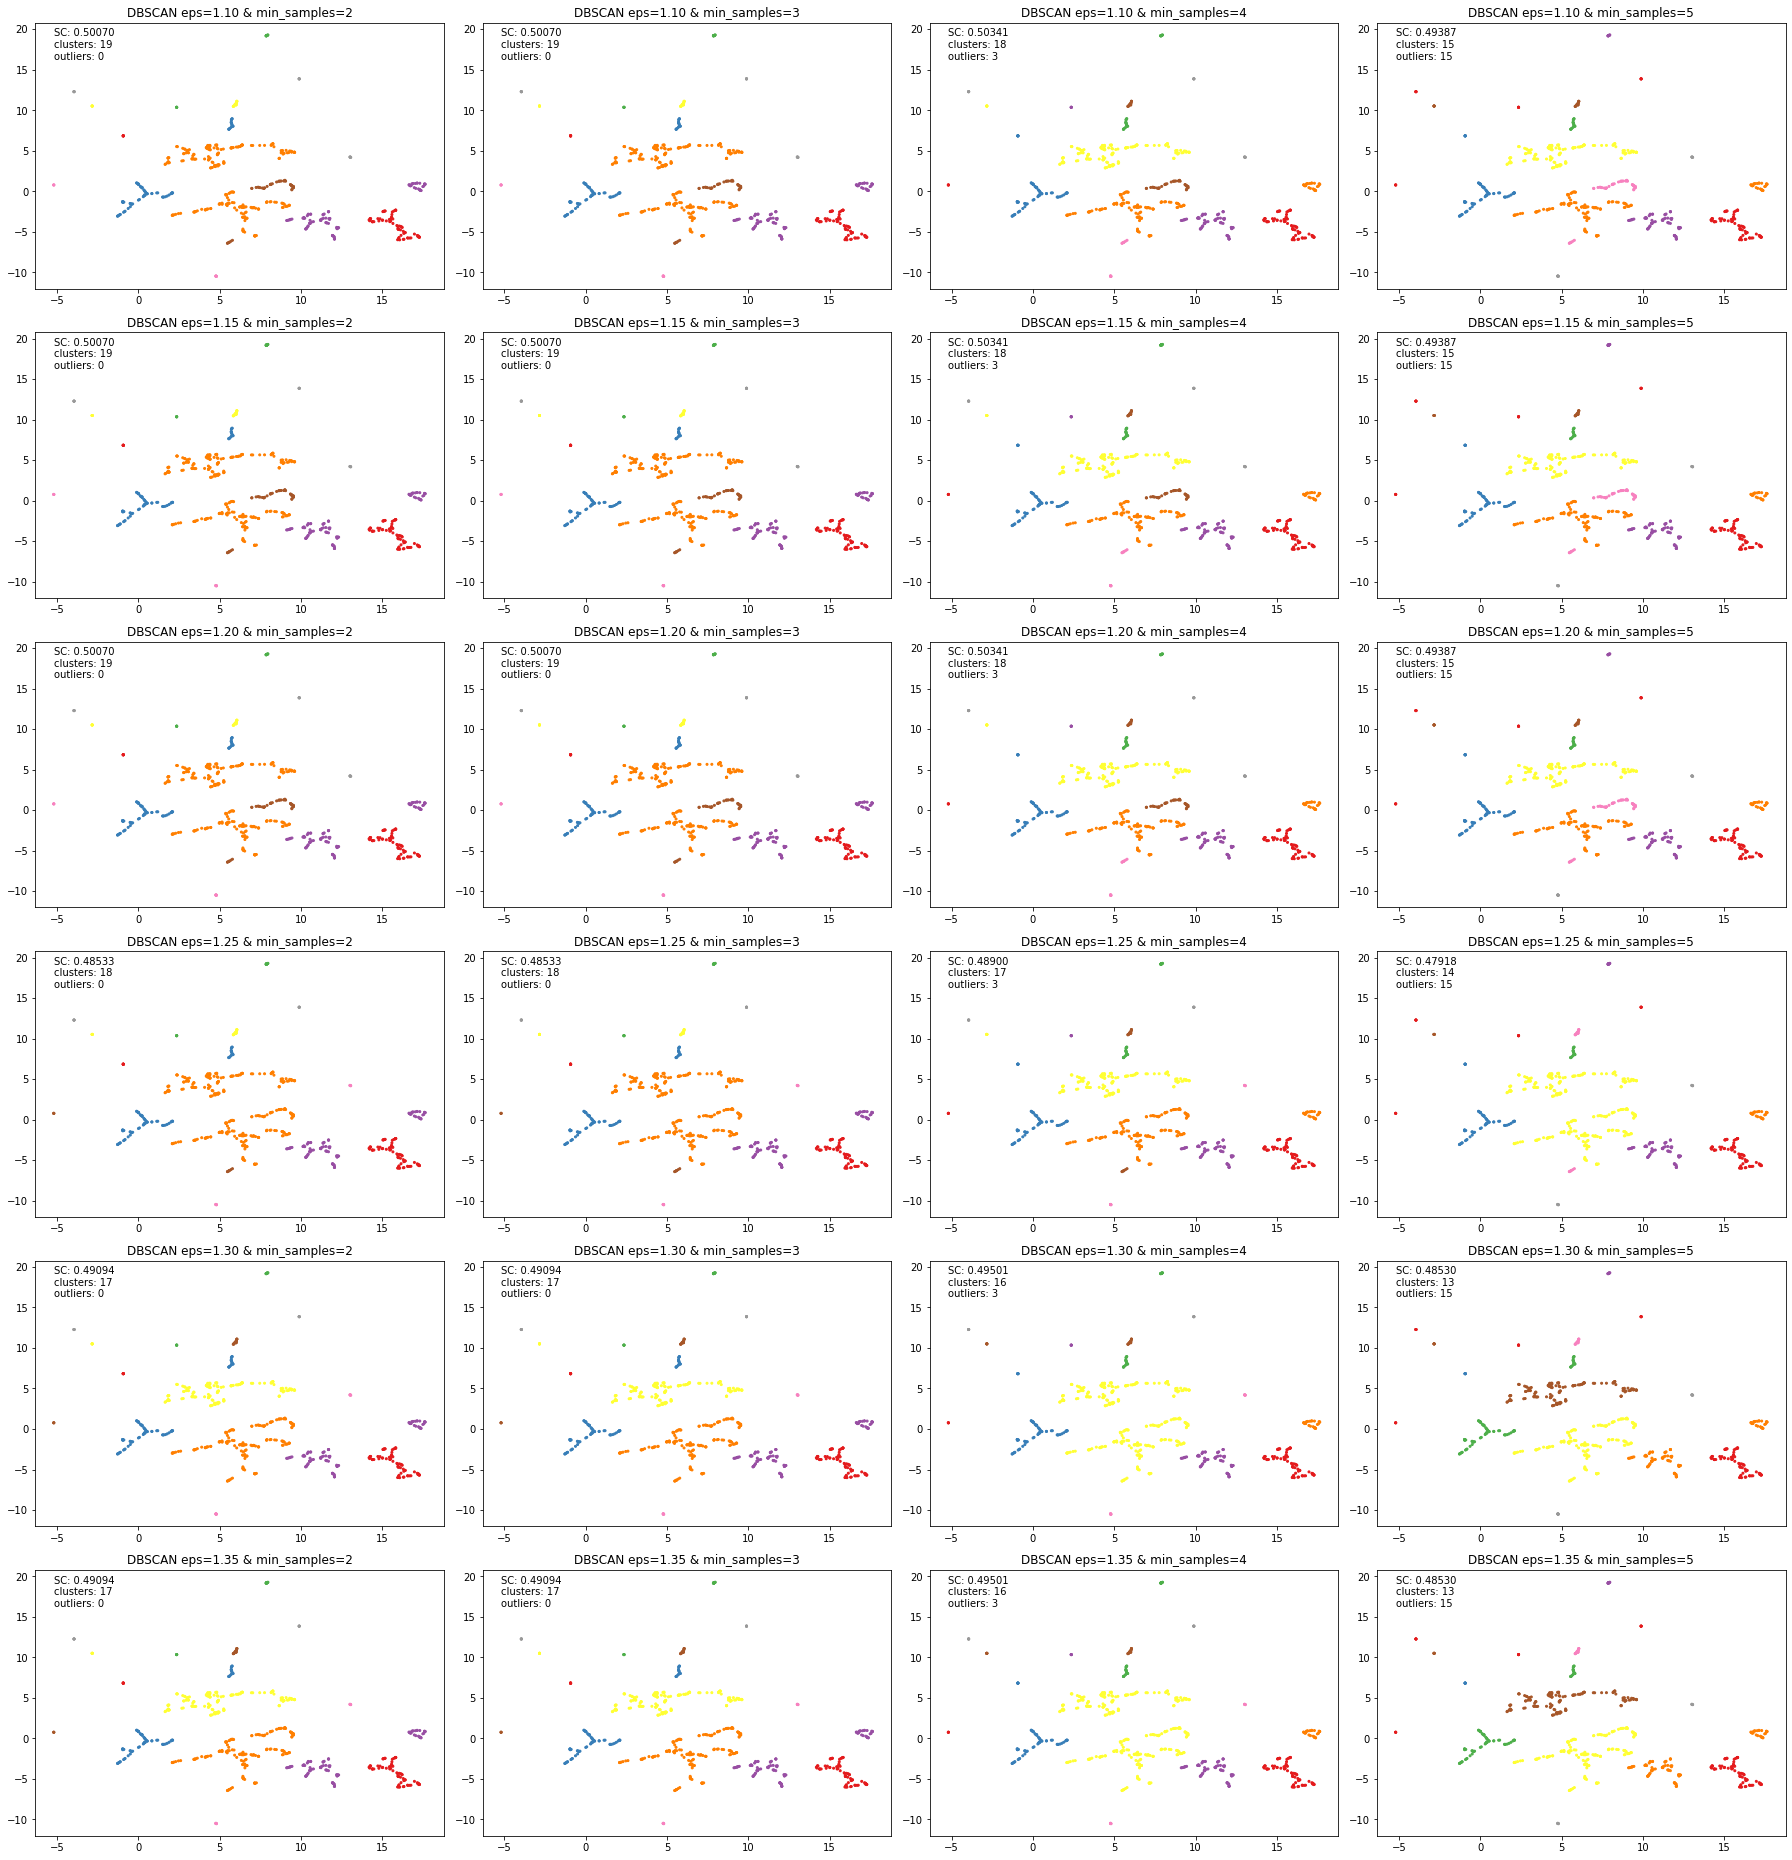

In [0]:
plt.figure(figsize=(25,30))
plot_no = 0
for eps in np.arange(1.1,1.4,0.05):
  for min_samples in np.arange(2,6):
    # Defining the clustering
    dbscan_cluster = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')

    # Fit model
    db_labels = dbscan_cluster.fit_predict(X_umap)
    db_labels_no_noise = db_labels[db_labels != -1]
    num_labels = len(np.unique(db_labels_no_noise))
    
    # don't include outliers when calculating silhouette coefficient
    db_labels_series = pd.Series(db_labels)
    indices = db_labels_series[db_labels_series != -1].index
    silco = metrics.silhouette_score(X_umap.iloc[indices], db_labels[indices], metric='euclidean')

    # plot resulting clusters
    plot_no = plot_no + 1
    plt.subplot(7,4,plot_no)
    plt.scatter(X_umap.iloc[:,0], X_umap.iloc[:,1], c=db_labels, s=4, cmap='Set1')
    plt.title("DBSCAN eps={:.2f} & min_samples={}".format(eps, min_samples))
    plt.text(X_umap.iloc[:,0].min(),
             X_umap.iloc[:,1].max()-3,
             s='SC: {:.5f}\nclusters: {}\noutliers: {}'.format(silco,num_labels,len(db_labels[db_labels == -1])))
plt.tight_layout()
plt.show()

We see that K-means does the best job clustering the low-dimensional data. This is a little unexpected since the clusters are not convex. Additionally, while we do see higher silhouette values for clusterings where k is larger than 18, we elect to use k=12, as it looks to be more reasonable from the visualization, and because the difference in silhouette coefficients is incredibly small.

In [0]:
# Defining the clustering
kmeans_cluster = KMeans(n_clusters=12, random_state=123)

# Fit model & and get labels
labels = kmeans_cluster.fit_predict(X_umap) + 1 # we add 1 so the first cluster is #1

#Examination of Clusters

We look through our clusters, using average statistics for each to determine the groups that excel at various fantasy categories.

In [0]:
# create a dataframe that has the fantasy relevant statistics,
# cluster labels, and player names.
clustered_players = pd.DataFrame()
clustered_players = pd.concat([player_stats.loc[:,['Name','G']], X], axis=1).reset_index().drop(columns='index')
clustered_players['label'] = labels
clustered_players.head()

,Name,G,R,HR,RBI,SB,BA,TB,RPG,HRPG,RBIPG,SBPG,TBPG,label
0,José Abreu,159,85,33,123,2,0.284,319,0.534591,0.207547,0.773585,0.012579,2.006289,2
1,Ronald Acuna Jr.,156,127,41,101,37,0.280,324,0.814103,0.262821,0.647436,0.237179,2.076923,7
2,Cristhian Adames,10,1,0,2,0,0.318,8,0.100000,0.000000,0.200000,0.000000,0.800000,3
3,Willy Adames,152,69,20,52,4,0.254,222,0.453947,0.131579,0.342105,0.026316,1.460526,2
4,Matt Adams,111,42,20,56,0,0.226,144,0.378378,0.180180,0.504505,0.000000,1.297297,10


Let's begin by examing the size of each cluster.

In [0]:
sizes = clustered_players['label'].value_counts().sort_index()
print(sizes)

1      40
2      76
3      76
4      26
5      19
6     110
7      15
8      70
9      60
10     38
11     76
12     29
Name: label, dtype: int64


Our cluster sizes are fairly balanced, wiht the exception of one particularly large cluster (#6) and two particularly small ones (#5 and #7). This is likely because we used K-means to cluster, and K-means tends to result in more balanced clusters.

Next, let's take a look at the average value for each statistic across each cluster.

In [0]:
cluster_avgs = clustered_players.groupby(by='label').mean()
cluster_avgs['size'] = sizes
cluster_avgs

,G,R,HR,RBI,SB,BA,TB,RPG,HRPG,RBIPG,SBPG,TBPG,size
label,,,,,,,,,,,,,
1,27.000000,9.225000,1.400000,6.600000,1.900000,0.203850,23.250000,0.298653,0.034857,0.199867,0.053568,0.705649,40
2,147.486842,86.000000,29.552632,87.197368,4.710526,0.265711,267.868421,0.580555,0.199155,0.589377,0.031972,1.809162,76
3,37.631579,10.644737,1.789474,8.842105,1.605263,0.222539,33.763158,0.228363,0.032053,0.223693,0.019765,0.766508,76
4,73.230769,34.461538,8.576923,27.615385,10.153846,0.216154,90.461538,0.424713,0.084149,0.300575,0.123841,1.013539,26
5,4.736842,0.000000,0.000000,0.000000,0.000000,0.091000,0.263158,0.000000,0.000000,0.000000,0.000000,0.029605,19
6,48.063636,22.190909,8.336364,23.290909,1.736364,0.215227,69.663636,0.414233,0.155250,0.437971,0.030432,1.301935,110
7,69.200000,45.133333,11.800000,30.666667,7.933333,0.166733,118.266667,0.411841,0.080419,0.238151,0.055754,0.867184,15
8,121.328571,58.671429,16.014286,53.385714,5.157143,0.256529,180.371429,0.480993,0.130382,0.435587,0.040688,1.477609,70
9,76.200000,27.050000,7.000000,31.633333,1.833333,0.236683,94.050000,0.344720,0.081607,0.378999,0.018078,1.147945,60


##Cluster summaries:

**Cluster 1**: Players who only played occasionally, and weren't especially productive when they did. Very low HR and BA, but an average 'SBPG' suggests these players are utility bench players and pinch runners (e.g. Roman Quinn & Byron Buxton)

**Cluster 2**: High R, HR, RBI, BA, TB total. Low SB totals. This cluster is typified by regular starters who hit for power. Six of 2019's top 10 HR hitters are in this cluster (Pete Alonso, Eugenio Suarez, Jorge Soler, Cody Bellinger, Alex Bregman & Nolan Arenado).

**Cluster 3**: Similar to Cluster 1, but with more games played, 20 points higher BA, and less than half the SBPG rate, and a lower RPG as well. Suggests bench players who are better hitters than baserunners (e.g. Cameron Maybin & Tommy Edman).

**Cluster 4**: Highest SBPG of all clusters. Low BA, but appearing in about half a team's games on average. This cluster is typified by regular starting basestealers who do not hit for average (e.g. Mallex Smith, Jarrod Dyson & Billy Hamilton).

**Cluster 5**: Players who almost never saw the field. Essentially a collection of players who played in fewer than 10 games total (e.g. who cares?).

**Cluster 6**: The largest cluster. 2nd highest in HRPG, but fewer than 50 games played on average. Typified by power hitters who didn't see the field much, either due to being bench players, or due to injury (e.g. Aaron Judge, Joey Gallo, Carlos Correa).

**Cluster 7**: This cluster is an unfortunate result of K-means. Inspection shows a combination of 13 inconsequential players with 6 who are actually exceptionally good, namely: Ronald Acuña Jr, Mookie Betts, Shin-Soo Choo, Francisco Lindor, Trevor Story, and Joey Votto. What happened here is UMAP moved players who were abnormally bad away from the group, and did the same with players who were abnormally good. The clusters ended up close enough together that K-means grouped them as one. All 6 of these players are elite power hitters who played in the majority of their team's games. We'll manually add these players to their own cluster (#13) after this discussion.

**Cluster 8**: These are players who appeared in most of their team's games, were definitely solid starters, but weren't elite. Numbers are good across board, but nothing stands out (e.g. Alex Gordon & Scott Kingery).

**Cluster 9**: Players who appeared in roughly half their team's games, didn't hit for power, mediocre BA, and didn't steal many bases. Overall, players who were 'just another guy' (e.g. Tucker Barnhart, Brandon Dixon & Jason Kipnis).

**Cluster 10**: Similar to Cluster 9, but with more production across the board. Not as good as Cluster 8, however. Better than average players, but not quite the fantasy production we see from Cluster 8 (e.g. Asdrubal Cabrera, Travis d'Arnaud & [old]Albert Pujols).

**Cluster 11**: Another group of 'just another guy's. Very similar to Cluster 9. As we'll see in the visualization later on, these two clusters are right next to each other, and are fittingly in the center of data.

**Cluster 12**: Highest BA of the clusters. 2nd highest steal rate. Very low HRPG. This cluster represents elite hitters who lack power. Excellent choices if you need BA and SB, but are all set for HRs (e.g. Elvis Andrus, Whit Merrifield & Trea Turner).

In [0]:
# list of players to reassign
missclass_players = ['Ronald Acuna Jr.', 'Mookie Betts', 'Shin-Soo Choo',
                      'Francisco Lindor', 'Trevor Story', 'Joey Votto']
# change labels
for name in missclass_players:
  clustered_players.loc[clustered_players['Name'] == name, 'label'] = 13
labels = np.array(clustered_players['label'])

# verify new cluster
clustered_players[clustered_players['label'] == 13]

,Name,G,R,HR,RBI,SB,BA,TB,RPG,HRPG,RBIPG,SBPG,TBPG,label
1,Ronald Acuna Jr.,156,127,41,101,37,0.280,324,0.814103,0.262821,0.647436,0.237179,2.076923,13
54,Mookie Betts,150,135,29,80,16,0.295,313,0.900000,0.193333,0.533333,0.106667,2.086667,13
110,Shin-Soo Choo,151,93,24,61,15,0.265,256,0.615894,0.158940,0.403974,0.099338,1.695364,13
329,Francisco Lindor,143,101,32,74,22,0.284,310,0.706294,0.223776,0.517483,0.153846,2.167832,13
550,Trevor Story,145,111,35,85,23,0.294,326,0.765517,0.241379,0.586207,0.158621,2.248276,13
603,Joey Votto,142,79,15,47,5,0.261,216,0.556338,0.105634,0.330986,0.035211,1.521127,13


##Cluster Locations

In [0]:
def show_cluster(label):
  '''
  Highlights the indicated cluster
  '''
  x_clust = X_umap.iloc[labels == label,0]
  y_clust = X_umap.iloc[labels == label,1]
  x_noclust = X_umap.iloc[labels != label,0]
  y_noclust = X_umap.iloc[labels != label,1]

  plt.scatter(x_clust, y_clust, c='r', s=5)
  plt.scatter(x_noclust, y_noclust, c='c', s=5)
  plt.title("Cluster #{}".format(label))

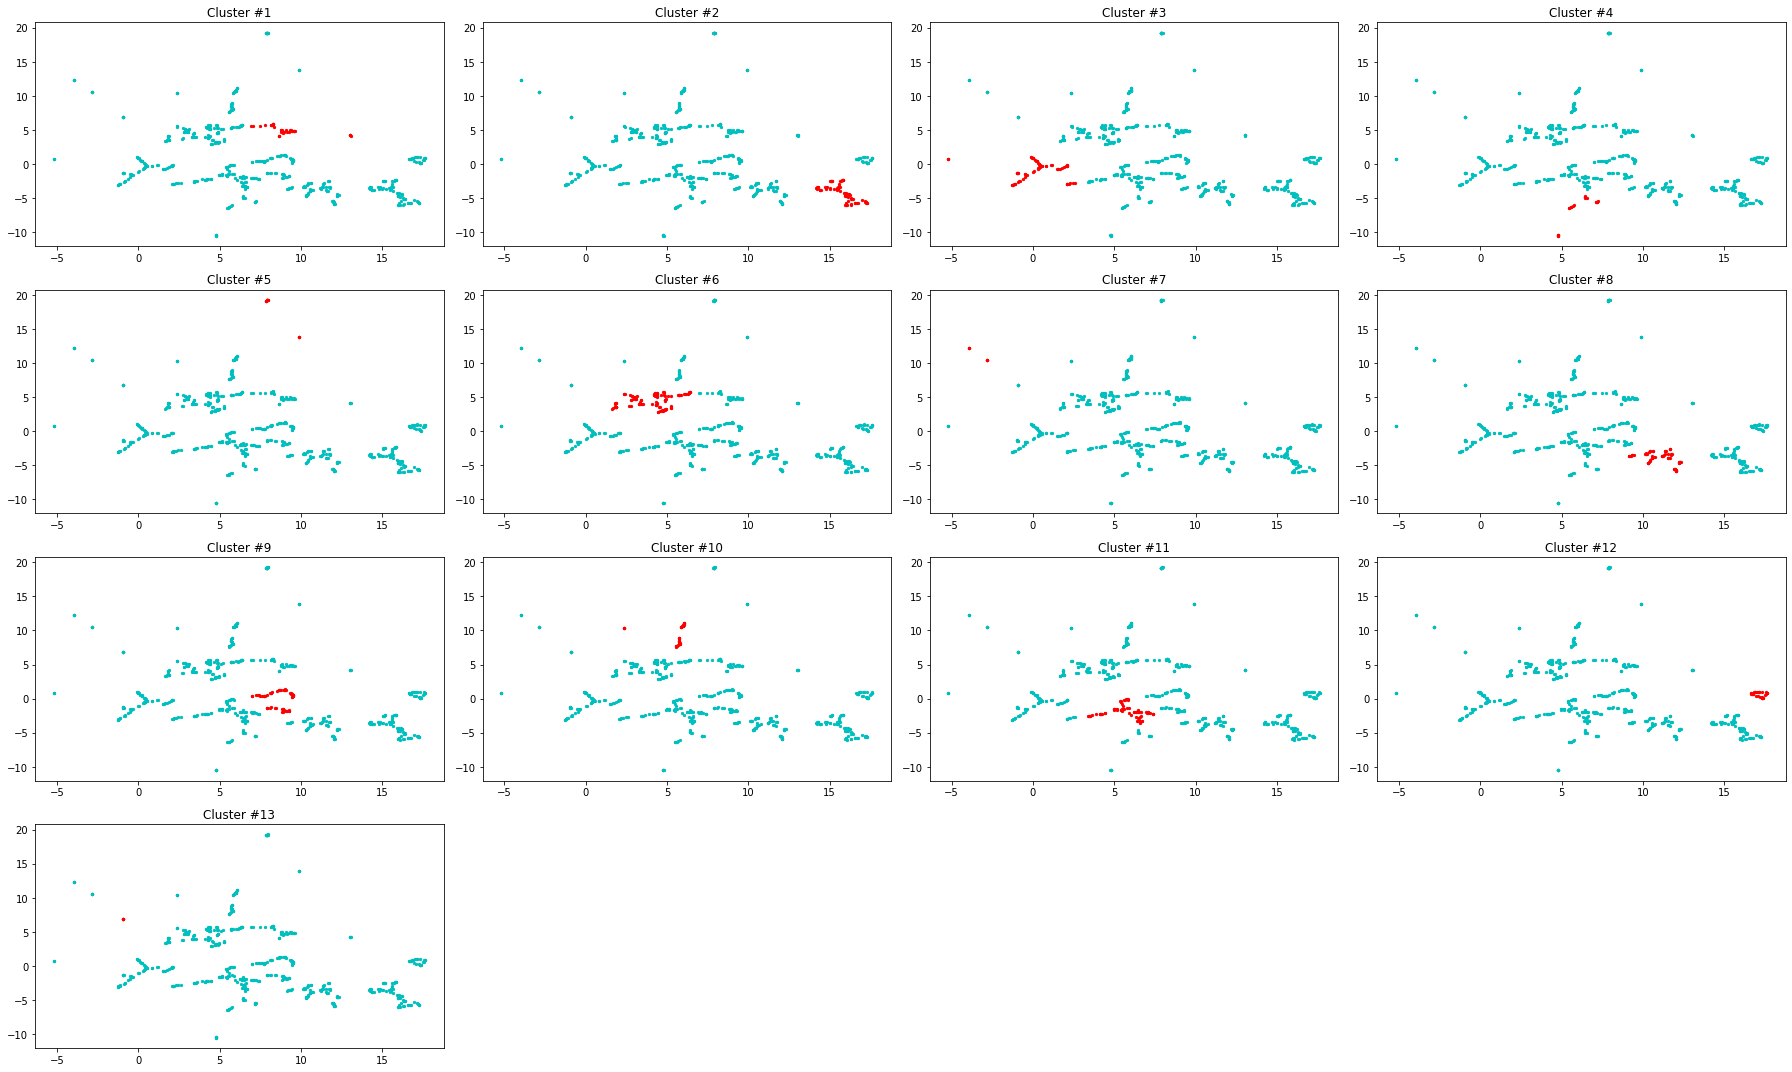

In [0]:
plt.figure(figsize=(25,15))
for label in range(1,clustered_players['label'].nunique()+1):
  plt.subplot(4,4,label)
  show_cluster(label)
plt.tight_layout()
plt.show()

As we can see from the visualizations, two of our best clusters, Cluster #2 and Cluster #12 are at the far right of our low-dimensional space. This is where the majority of our best fantasy players have ended up. The worst players Cluster #5 and Cluster #7 are towards the top and left of the space. The exception is the 6 players we identified and moved to their own cluster: Cluster #13. These are elite players who have somehow ended up isolated towards the left end of the space.

#Conclusion

Overall, this model did a good job of clustering players based on their fantasy performance. We were able to identify two large clusters of players with their own unique elite scoring skills, as ws well as a smaller cluster of talent that almost slipped through the cracks. Additionally, we've identified groups of solid players, as well as players to avoid completely. To summarize, on draft day, the clusters break down like so.

Tier        | Clusters
------------|----------
1 (elite)   | 2, 12, 13
2           | 6, 10
3 (average) | 4, 8
4           | 3, 9, 11
5 (bad)     | 1, 5, 7

Players who are drafting are best suited looking at players from the best cluster remaining. This could be used for making a draft strategy, and putting together player pools for an ideal team.

The model does have some shortcomings:

1. There were elite players who were almost clustered with a bad group. It was only 6 players, but it's surprising that they were isolated so far from the rest of the elite players in the 2-D space.
2. I tried to have the model include player positions into the clustering, but it was difficult to get the model to do so while still giving due consideration to scoring stats. The results were usually just clusters based on position alone with a mix of scoring within.

The next steps would be to perhaps do the clustering in two passes. First, we can cluster players on their positions. Group together players who are pure corner infielders, for example, and players who can be both middle infielders as well as outfielders. After these clusters are formed, each cluster could be further grouped by scoring stats. This would provide a draft pool that allows the planner to incorporate which roster positions they want/need to fill more easily.